## Setup



### Import libraries

In [ ]:
%matplotlib inline

from functools import partial
import itertools
import math
from textwrap import wrap
import time

from dataclasses import dataclass
from google.colab import drive
import jax
# from jax.example_libraries import optimizers
import jax.nn as jnn
import jax.numpy as jnp
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pickle
import scipy.optimize
import scipy.stats
import scipy.stats
from sklearn import metrics

# Configure plot style sheet
plt.style.use('fivethirtyeight')
plt.rcParams['axes.titlesize'] = 'medium'  # can take 'large', 'x-large'
plt.rcParams['axes.labelsize'] = 'medium'

# Mount drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Define constants

In [ ]:
# basic configuration
N_RSSI_BUCKETS = 4
N_INFECT_LEVELS = 3
RSSI_LOWEST_TH = -100  # corresponds to a BLE of 97 dB
N_RSSI_TH = N_RSSI_BUCKETS-1  # number of thresholds for rssi buckets
MODEL_DIM = 1 + N_RSSI_BUCKETS + N_RSSI_TH + N_INFECT_LEVELS  # total number of parameters
N_RESTARTS = 2  # random restarts for training

### Define data classes

In [ ]:
@dataclass
class BleParams:
  """Parameters to translate BLE signals into distance."""
  slope: float = 0.21
  intercept: float = 3.92
  sigma: float = np.sqrt(0.33)
  tx: float = 0.0
  correction: float = 2.398
  name: str = 'briers-lognormal'

@dataclass
class ModelParams:
  """Parameters necessary to simulate infectious interactions."""
  ble_params: BleParams = BleParams()  # may want to change sigma
  distance_fun: str = 'quadratic'  # quadratic  or sigmoid
  distance_Dmin: float = 1.0
  distance_slope: float = 2.0
  distance_inflection: float = 2.0
  infectiousness_fun: str = 'skew-logistic'  # gaussian or skew-logistic
  beta: float = 0.8*1e-3  # transmission rate to approximate Wilson (2020) paper

@dataclass
class RiskConfig:
  """Parameters necessary to predict risk of infectious transmission."""
  ble_thresholds: jnp.array = jnp.array([])
  ble_weights: jnp.array = jnp.array([])
  inf_levels: jnp.array = jnp.array([])
  inf_weights: jnp.array = jnp.array([])
  name: str = ''
  beta: float = 3.1 * 1e-4 # Wilson table 1 (divide by 100)

@dataclass
class TrainConfig:
  """Parameters necessary to learn the risk config."""
  sigmoid_temp_init: float = 0.1
  sigmoid_temp_target: float = 1
  rssi_th_init: jnp.array = None
  opt_type: str = 'gd'
  hessian_reg: float = 0.01
  batch_size: int = 500
  num_iters: int = 5000
  lr: float = 0.001
  opt_two_stage: bool = False
  tol: float = 1e-6

### Define published configurations

In [ ]:
def make_ble_params_v1():
  """Arizona parameters scaled up by 100 to match PHA parameters."""
  thresholds = np.array([50, 70])
  weights = np.array([2.39, 0.6, 0.06])
  return thresholds, weights


def make_ble_params_v2():
  # Extrapolated from Arizona parameters
  thresholds = np.array([50, 70, 80])
  weights = np.array([2.39, 0.6, 0.06, 0.01])
  return thresholds, weights

  
def make_infectiousness_params_v1():
  # Arizona settings
  inf_pre = np.zeros((9), dtype=int)
  inf_post = np.zeros((5), dtype=int)
  inf_mid = np.array([1, 3, 4, 5, 6, 6, 6, 6, 5, 4, 3, 2, 2, 1, 1])
  inf_levels = np.concatenate((inf_pre, inf_mid, inf_post))
  inf_weights = np.array([0, 10**1, 10**1.2, 10**1.4, 10**1.6, 10**1.8, 10**2])/100
  return inf_levels, inf_weights


def make_infectiousness_params_v2():
  # Derived from Arizona by averaging some bins
  inf_pre = np.zeros((9), dtype=int)
  inf_post = np.zeros((5), dtype=int)
  inf_mid6 = np.array([1, 3, 4, 5, 6, 6, 6, 6, 5, 4, 3, 2, 2, 1, 1])
  inf_mid = np.ones_like(inf_mid6)
  ndx = (inf_mid6 >= 5)
  inf_mid[ndx] = 2
  #inf_mid = np.array([1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1])
  inf_levels = np.concatenate((inf_pre, inf_mid, inf_post))
  inf_weights = np.array([0,  10**1.6, 10**2])/100
  return inf_levels, inf_weights

In [ ]:
# Published configs are just for v1 of the API

# Currently most PHAs ignore exposures with sympton onset earlier than -2 days.
# Apart from that, they treat all infectiousness levels equally.
inf_levels_drop = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,    1,    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int)
assert len(inf_levels_drop)==len(np.arange(-14,14+0.1))
inf_weights_unif = np.array([0, 100, 100])/100 # drop, standard, high

config_swiss = RiskConfig(ble_thresholds = np.array([55, 63]),
                          ble_weights = np.array([100, 50, 0])/100,
                          inf_levels = inf_levels_drop,
                          inf_weights = inf_weights_unif,
                          name= 'Switzerland')

print(config_swiss)


config_ireland = RiskConfig(ble_thresholds = np.array([56, 62]),
                            ble_weights = np.array([100, 100, 0])/100,
                            inf_levels = inf_levels_drop,
                            inf_weights = inf_weights_unif,
                            name= 'Ireland')

config_virginia = RiskConfig(ble_thresholds = np.array([55, 63]),
                          ble_weights = np.array([100, 50, 0])/100, 
                          inf_levels = inf_levels_drop,
                          inf_weights = inf_weights_unif,
                          name= 'Virginia')

levels, weights = make_infectiousness_params_v1()
thresholds, ble_weights = make_ble_params_v1()
config_arizona = RiskConfig(ble_thresholds = thresholds,
                            ble_weights = ble_weights,
                            inf_weights = weights,
                            inf_levels = levels,
                            name = 'Arizona')

print(config_arizona)

# Baseline config is derived from Arizona.
levels, weights = make_infectiousness_params_v2()
thresholds, ble_weights = make_ble_params_v2()
config_baseline = RiskConfig(ble_thresholds = thresholds,
                            ble_weights = ble_weights,
                            inf_weights = weights,
                            inf_levels = levels,
                            name = 'Baseline')

print(config_baseline)
config_list = [config_baseline, config_arizona, config_swiss, config_ireland]

RiskConfig(ble_thresholds=array([55, 63]), ble_weights=array([1. , 0.5, 0. ]), inf_levels=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1]), inf_weights=array([0., 1., 1.]), name='Switzerland', beta=0.00031)
RiskConfig(ble_thresholds=array([50, 70]), ble_weights=array([2.39, 0.6 , 0.06]), inf_levels=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 4, 5, 6, 6, 6, 6, 5, 4, 3, 2, 2,
       1, 1, 0, 0, 0, 0, 0]), inf_weights=array([0.        , 0.1       , 0.15848932, 0.25118864, 0.39810717,
       0.63095734, 1.        ]), name='Arizona', beta=0.00031)
RiskConfig(ble_thresholds=array([50, 70, 80]), ble_weights=array([2.39, 0.6 , 0.06, 0.01]), inf_levels=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0]), inf_weights=array([0.        , 0.39810717, 1.        ]), name='Baseline', beta=0.00031)


### Define train configurations

In [ ]:
# Random initialization of risk model parameters
config_init = RiskConfig(inf_levels = make_infectiousness_params_v2()[0], name='Init')

# TrainConfig for SGD optimizer and sigmoid thresholds
train_config_temp = TrainConfig()

# TrainConfig for SGD optimizer and hard thresholds
train_config_step = TrainConfig(batch_size=500, num_iters=3000)

# TrainConfig for SQP optimizer
train_config_sqp = TrainConfig(tol=1e-6)

## Simulation functions

### Define distance functions

In [ ]:
def atten_to_rssi(atten, ble_params):
  return ble_params.tx  - (atten + ble_params.correction)


def rssi_to_atten(rssi, ble_params):
  return ble_params.tx - (rssi + ble_params.correction)


def atten_to_dist(atten, ble_params):
  rssi = ble_params.tx  - (atten + ble_params.correction)
  return np.exp((np.log(-rssi) - ble_params.intercept)/ble_params.slope)


def dist_to_atten(distance, ble_params):
  mu = ble_params.intercept + ble_params.slope * np.log(distance)
  rssi = -np.exp(mu)
  atten = ble_params.tx  - (rssi + ble_params.correction)
  return atten


def dist_to_atten_sample(distances, ble_params):
    if ble_params.sigma == 0:
      return dist_to_atten(distances, ble_params)
    N = len(distances)
    mus = ble_params.intercept + ble_params.slope * np.log(distances)
    sigs = ble_params.sigma
    rssi = -scipy.stats.lognorm(s=sigs, scale=np.exp(mus)).rvs()
    atten = ble_params.tx  - (rssi + ble_params.correction)
    return atten


def make_ble_params_v1():
  """Arizona parameters scaled up by 100 to match PHA parameters."""
  thresholds = np.array([50, 70])
  weights = np.array([2.39, 0.6, 0.06])
  return thresholds, weights


def make_ble_params_v2():
  # Extrapolated from Arizona parameters
  thresholds = np.array([50, 70, 80])
  weights = np.array([2.39, 0.6, 0.06, 0.01])
  return thresholds, weights

### Define infectiousness functions

In [ ]:
def make_infectiousness_params_v1():
  # Arizona settings
  inf_pre = np.zeros((9), dtype=int)
  inf_post = np.zeros((5), dtype=int)
  inf_mid = np.array([1, 3, 4, 5, 6, 6, 6, 6, 5, 4, 3, 2, 2, 1, 1])
  inf_levels = np.concatenate((inf_pre, inf_mid, inf_post))
  inf_weights = np.array([0, 10**1, 10**1.2, 10**1.4, 10**1.6, 10**1.8, 10**2])/100
  return inf_levels, inf_weights


def make_infectiousness_params_v2():
  # Derived from Arizona by averaging some bins
  inf_pre = np.zeros((9), dtype=int)
  inf_post = np.zeros((5), dtype=int)
  inf_mid6 = np.array([1, 3, 4, 5, 6, 6, 6, 6, 5, 4, 3, 2, 2, 1, 1])
  inf_mid = np.ones_like(inf_mid6)
  ndx = (inf_mid6 >= 5)
  inf_mid[ndx] = 2
  #inf_mid = np.array([1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1])
  inf_levels = np.concatenate((inf_pre, inf_mid, inf_post))
  inf_weights = np.array([0,  10**1.6, 10**2])/100
  return inf_levels, inf_weights


def days_to_inf_levels(symptom_days):
  symptom_days = np.atleast_1d(symptom_days)  # turn into array
  inf_levels, _ = make_infectiousness_params_v2()
  return inf_levels[symptom_days + 14]

### Simulate grid of data

In [ ]:
def make_input_data_train(sigma=0.1, nsamples=20, ble_params=BleParams(), density=10):
  eps = 0.001 # hack to make np.arange include endpoint
  ble_params.sigma = sigma
  attens = np.linspace(20, 80, 5*density)  # dB - directly correspond to thresholds
  distances = atten_to_dist(attens, ble_params)
  durations = np.arange(5, 60+eps, 50/density)  # minutes
  symptoms = np.arange(-10, 10+eps, dtype=int)  # must be int

  # Shuffle data to decorrelate observations
  np.random.seed(60240)
  np.random.shuffle(distances)
  np.random.shuffle(durations)
  np.random.shuffle(symptoms)
  
  # For evaluating functions over cross product of 3d inputs
  vals = itertools.product(distances, durations, symptoms)
  X = np.vstack([np.array(v) for v in vals])
  distance_grid = X[:,0]
  atten_grid = dist_to_atten(distance_grid, ble_params)  # noise-free
  atten_grid_samples = []
  for n in range(nsamples):
    sample = dist_to_atten_sample(distance_grid, ble_params)
    atten_grid_samples.append(sample)
  duration_grid = X[:,1]
  symptom_grid = np.array(X[:,2], dtype=int)
  
  # For plotting functions over 2d grid of inputs (sym x atten)
  grid_2d_matrix = np.meshgrid(symptoms, attens)
  symptom_grid_2d_matrix, atten_grid_2d_matrix  = grid_2d_matrix
  vals = [z for z in zip(*(x.flat for x in grid_2d_matrix))]
  X = np.vstack([np.array(v) for v in vals])
  symptom_grid_2d = np.array(X[:,0], dtype=int)
  atten_grid_2d = X[:,1]


  data = {'distances': distances, 'attens': attens, 'durations': durations, 'symptoms': symptoms, 
          'distance_grid': distance_grid, 'atten_grid': atten_grid, 
          'duration_grid': duration_grid, 'symptom_grid': symptom_grid,
          'symptom_grid_2d_matrix': symptom_grid_2d_matrix,
          'atten_grid_2d_matrix': atten_grid_2d_matrix,
          'symptom_grid_2d': symptom_grid_2d,
          'atten_grid_2d': atten_grid_2d,
          'atten_grid_samples': atten_grid_samples,
          'noise_level': ble_params.sigma, 'nsamples': nsamples}
  return data


def make_input_data_test(sigma=0.1, nsamples=20, ble_params=BleParams(), is_random=False):
  eps = 0.001 # hack to make np.arange include endpoint
  ble_params.sigma = sigma
  if is_random:
    np.random.seed(114027)
    attens = np.random.uniform(20, 80, 50)
    distances = atten_to_dist(attens, ble_params)
    durations = np.random.uniform(5, 60, 12)  # minutes
    symptoms = np.random.randint(-10, 11, 21)  # must be int
  else:
    attens = np.linspace(23, 83, 50)  # dB - directly correspond to thresholds
    distances = atten_to_dist(attens, ble_params)
    durations = np.arange(7, 62+eps, 5)  # minutes
    symptoms = np.arange(-10, 10+eps, dtype=int)  # must be int
  
  # For evaluating functions over cross product of 3d inputs
  vals = itertools.product(distances, durations, symptoms)
  X = np.vstack([np.array(v) for v in vals])
  distance_grid = X[:,0]
  atten_grid = dist_to_atten(distance_grid, ble_params)  # noise-free
  atten_grid_samples = []
  for n in range(nsamples):
    sample = dist_to_atten_sample(distance_grid, ble_params)
    atten_grid_samples.append(sample)
  duration_grid = X[:,1]
  symptom_grid = np.array(X[:,2], dtype=int)
  
  # For plotting functions over 2d grid of inputs (sym x atten)
  grid_2d_matrix = np.meshgrid(symptoms, attens)
  symptom_grid_2d_matrix, atten_grid_2d_matrix  = grid_2d_matrix
  vals = [z for z in zip(*(x.flat for x in grid_2d_matrix))]
  X = np.vstack([np.array(v) for v in vals])
  symptom_grid_2d = np.array(X[:,0], dtype=int)
  atten_grid_2d = X[:,1]


  data = {'distances': distances, 'attens': attens, 'durations': durations, 'symptoms': symptoms, 
          'distance_grid': distance_grid, 'atten_grid': atten_grid, 
          'duration_grid': duration_grid, 'symptom_grid': symptom_grid,
          'symptom_grid_2d_matrix': symptom_grid_2d_matrix,
          'atten_grid_2d_matrix': atten_grid_2d_matrix,
          'symptom_grid_2d': symptom_grid_2d,
          'atten_grid_2d': atten_grid_2d,
          'atten_grid_samples': atten_grid_samples,
          'noise_level': ble_params.sigma, 'nsamples': nsamples}
  return data

## Model functions

### Define true model

In [ ]:
# Distance to dose
def transmission_vs_distance_quadratic(d, Dmin=1):
  m = np.power(Dmin,2)/np.power(d, 2)
  return np.minimum(1, m)


# Symptom days to infectiousness
def skew_logistic_scaled(x, alpha, mu, sigma):
  return scipy.stats.genlogistic.pdf(x, alpha, loc=mu, scale=sigma)


def ptost_conditional(ts, incubation):
  mu = -4
  sigma = 1.85
  alpha = 5.85
  tau = 5.42
  fpos = skew_logistic_scaled(ts, alpha, mu, sigma)
  fneg = skew_logistic_scaled(ts*tau/incubation, alpha, mu, sigma)
  ps = fpos
  neg = jnp.where(ts < 0)
  ps[neg] = fneg[neg]
  ps = ps/np.max(ps)
  return ps


def incubation_dist(t):
  mu = 1.621
  sig = 0.418
  rv = scipy.stats.lognorm(sig, scale=np.exp(mu))
  return rv.pdf(t)


def ptost_uncond(tost_times):
  incub_times = np.arange(1, 14, 1)
  incub_probs = incubation_dist(incub_times) 
  tost_probs = np.zeros_like(tost_times, dtype=float)
  for k, incub in enumerate(incub_times):
    ps = ptost_conditional(tost_times, incub)
    tost_probs += incub_probs[k] * ps
  return tost_probs


infectiousness_curve_times = np.arange(-14, 14+1, 0.1)
infectiousness_curve_vals = ptost_uncond(infectiousness_curve_times)


def infectiousness_skew_logistic(delta):
  return np.interp(delta, infectiousness_curve_times, infectiousness_curve_vals)


def hazard_fun_batch(attenuations, durations, symptom_days, params, distances=None):
  """ Transmission model.
  Args:
    params = ModelParams() object.
  """
  if distances is None:
    distances = atten_to_dist(attenuations, params.ble_params)
  if params.distance_fun == 'quadratic':
    fd = transmission_vs_distance_quadratic(distances, params.distance_Dmin)
  elif params.distance_fun == 'sigmoid':
    fd = transmission_vs_distance_sigmoid(distances, params.distance_slope, params.distance_inflection)
  elif params.distance_fun == 'spline':
    fd = transmission_vs_distance_spline(distances)
  if params.infectiousness_fun == 'gaussian':
    finf = infectiousness_gaussian(symptom_days) 
  elif params.infectiousness_fun == 'skew-logistic':
    finf = infectiousness_skew_logistic(symptom_days)
  doses  = durations * fd * finf 
  return doses


def prob_infection_batch(attenuations, durations, symptom_days, params, distances=None):
  """
  Args:
    params = ModelParams() object.
  """
  doses = hazard_fun_batch(attenuations, durations, symptom_days, params, distances)
  return 1-np.exp(-params.beta * doses)


def prob_infection_grid(data, params):
  """
  Args:
    data = dictionary obtained from make_input_data_train().
    params = ModelParams() object.
  """
  ps = prob_infection_batch(data['atten_grid'], data['duration_grid'], data['symptom_grid'], params)
  return ps

### Define risk model

In [ ]:
def get_one_hot(targets, num_classes):
  # https://stackoverflow.com/questions/38592324/one-hot-encoding-using-numpy
  I = jnp.eye(num_classes)
  r = jnp.atleast_1d(targets)
  res = I[r]
  s = list(r.shape) + [num_classes]
  return res.reshape(s)


def attenuation_score_batch(attenuations, thresholds, weights):
  # Map each attenuation to the corresponding bucket
  # and return the corresponding set of weights.
  attenuations = jnp.atleast_1d(attenuations)
  labels = jnp.digitize(attenuations, thresholds)
  vecs = get_one_hot(labels, num_classes = len(weights))
  tmp = jnp.multiply(weights, vecs)
  scores = jnp.sum(tmp, 1)
  return scores


def infectiousness_score_batch(symptom_days, inf_levels, inf_weights): 
  # Map each symptom onset day to a level, and return the correspond weights.
  # symptom_days is an array of ints in -14..14
  symptom_days = jnp.atleast_1d(symptom_days)
  inf_labels = inf_levels[symptom_days + 14]
  inf_vecs = get_one_hot(inf_labels, num_classes = len(inf_weights))
  tmp = jnp.multiply(inf_weights, inf_vecs)
  scores = jnp.sum(tmp, 1)
  return scores


def risk_score_batch(attenuations, durations, symptom_days, config):
  attenuations = jnp.atleast_1d(attenuations)
  durations = jnp.atleast_1d(durations)
  symptom_days = jnp.atleast_1d(symptom_days)
  winf = infectiousness_score_batch(symptom_days, config.inf_levels, config.inf_weights)
  watten = attenuation_score_batch(attenuations, config.ble_thresholds, config.ble_weights)
  risks = durations * watten * winf
  return risks


def prob_risk_score_batch(attenuations, durations, symptom_days, config):
  risks = risk_score_batch(attenuations, durations, symptom_days, config)
  probs = 1-jnp.exp(-config.beta * risks)
  return probs


def risk_score_grid(data, config):
  rs = risk_score_batch(data['atten_grid'], data['duration_grid'], data['symptom_grid'], config)
  return rs


def prob_risk_score_grid(data, config):
  qs = prob_risk_score_batch(data['atten_grid'], data['duration_grid'], data['symptom_grid'], config)
  return qs

## Training functions

### Initialize parameters



In [ ]:
def get_init_parameters(rssi_th=None):
  """Initial (residual) parameters for learning. """

  # overall scaling
  beta = 0.1

  # rssi weights
  residual_rssi_w = np.random.rand(N_RSSI_BUCKETS - 1) * 0.01
  rssi_w = [None] * N_RSSI_BUCKETS
  rssi_w[0] = np.random.rand() * 0.01
  for i in range(N_RSSI_BUCKETS - 1):
    rssi_w[i + 1] = rssi_w[i] + residual_rssi_w[i]

  # rssi thresholds
  if rssi_th is None:
    residual_rssi_th = np.random.randint(low=10, high=30, size=N_RSSI_TH)
    # residual_rssi_th = [30, 20, 30]
    rssi_th = [None] * N_RSSI_TH
    prev = RSSI_LOWEST_TH
    for i in range(N_RSSI_TH):
      rssi_th[i] = prev + residual_rssi_th[i]
      prev = rssi_th[i]

  # infectiousness weights
  residual_infect_w = np.random.rand(N_INFECT_LEVELS) * 0.01
  infect_w = [None] * N_INFECT_LEVELS
  infect_w[0] = np.random.rand() * 0.01
  for i in range(N_INFECT_LEVELS - 1):
    infect_w[i + 1] = infect_w[i] + residual_infect_w[i]


  # score parameters (parameters used for calculating score)
  weights_score = [None] * MODEL_DIM
  weights_score[0] = beta 
  ind = 1
  weights_score[ind:ind+N_RSSI_BUCKETS] = rssi_w
  ind += N_RSSI_BUCKETS
  weights_score[ind:ind+N_RSSI_TH] = rssi_th
  ind += N_RSSI_TH
  weights_score[ind:ind+N_INFECT_LEVELS] = infect_w

  # convert to residual parameters  
  weights_residual = get_residual_parameters(weights_score)  
  return weights_residual


def get_residual_parameters(weights):
  """Transform scoring parameters to learnable residual parameters. Inverse transform of 'get_scoring_parameters()'.

  Args:
    weights: scoring parameters
  """ 
  weights = np.array(weights)
  beta = weights[0] 
  ind = 1
  rssi_w = weights[ind:ind+N_RSSI_BUCKETS]
  ind += N_RSSI_BUCKETS
  rssi_th = weights[ind:ind+N_RSSI_TH]
  ind += N_RSSI_TH
  infect_w = weights[ind:ind+N_INFECT_LEVELS]
  
  # rssi weights
  residual_rssi_w = [None] * N_RSSI_BUCKETS
  w_prev = 0
  for i in range(N_RSSI_BUCKETS):
    residual_rssi_w[i] = rssi_w[i] - w_prev
    w_prev = rssi_w[i]

  # rssi bucket thresholds
  residual_rssi_th = [None] * N_RSSI_TH
  th_prev = RSSI_LOWEST_TH
  for i in range(N_RSSI_TH):
    residual_rssi_th[i] = rssi_th[i] - th_prev
    th_prev = rssi_th[i]

  # infectiousness weights
  residual_infect_w = [None] * N_INFECT_LEVELS
  w_prev = 0
  for i in range(N_INFECT_LEVELS):
    residual_infect_w[i] = infect_w[i] - w_prev
    w_prev = infect_w[i]

  weights_residual = [beta,] + residual_rssi_w + residual_rssi_th + list(residual_infect_w)
  return np.asarray(weights_residual)


@jax.jit
def get_scoring_parameters(weights):
  """Transform residual parameters to scoring parameters (that respect monotonocity constraints). 

  Args:
    weights: residual parameters (nonnegative)
  """    
  beta = weights[0]
  ind = 1
  residual_rssi_w = weights[ind:ind+N_RSSI_BUCKETS]
  ind += N_RSSI_BUCKETS
  residual_rssi_th = weights[ind:ind+N_RSSI_TH]
  ind += N_RSSI_TH
  residual_infect_w = weights[ind:ind+N_INFECT_LEVELS]

  # rssi weights
  rssi_w = [None] * N_RSSI_BUCKETS
  w_prev = 0
  for i in range(N_RSSI_BUCKETS):
    rssi_w[i] = w_prev + residual_rssi_w[i]
    w_prev = rssi_w[i]    

  # rssi thresholds
  rssi_th = [None] * N_RSSI_TH
  w_prev = RSSI_LOWEST_TH
  for i in range(N_RSSI_TH):
    rssi_th[i] = w_prev + residual_rssi_th[i]
    w_prev = rssi_th[i]    

  # infectiousness weights
  infect_w = [None] * N_INFECT_LEVELS
  w_prev = 0
  for i in range(N_INFECT_LEVELS):
    infect_w[i] = w_prev + residual_infect_w[i]
    w_prev = infect_w[i]

  weights_scoring = [None] * MODEL_DIM
  weights_scoring[0] = beta
  ind = 1
  weights_scoring[ind:ind+N_RSSI_BUCKETS] = rssi_w
  ind += N_RSSI_BUCKETS
  weights_scoring[ind:ind+N_RSSI_TH] = rssi_th
  ind += N_RSSI_TH
  weights_scoring[ind:ind+N_INFECT_LEVELS] = infect_w  
  return weights_scoring


def print_params(weights):
  """print parameters"""
  beta = weights[0]
  ind = 1
  rssi_w = weights[ind:ind+N_RSSI_BUCKETS]
  ind += N_RSSI_BUCKETS
  rssi_th = weights[ind:ind+N_RSSI_TH]
  ind += N_RSSI_TH
  infect_w = weights[ind:ind+N_INFECT_LEVELS]
  print ('\tbeta: {:.6f}'.format(beta))
  print ('\trssi_w: {}'.format([round(w,3) for w in rssi_w]))
  print ('\trssi_th: {}'.format([round(w,4) for w in rssi_th]))
  print ('\tinfectiousness: {}'.format([round(w,2) for w in infect_w]))

### Hazard and loss functions (SGD)

In [ ]:
@partial(jax.jit, static_argnums=())
def hazard_sigmoid_buckets(features, weights, sigmoid_temp):
  """Implement multi-linear hazard function with sigmoid buckets."""
  f_rssi = features[0]  
  f_duration = features[1]
  f_infectiousness = features[2]
  
  # transform residual model parameters to scoring parameters
  weights_scoring = get_scoring_parameters(weights)
  beta = weights_scoring[0]
  ind = 1
  rssi_w = weights_scoring[ind:ind+N_RSSI_BUCKETS]
  ind += N_RSSI_BUCKETS
  rssi_th = weights_scoring[ind:ind+N_RSSI_TH]
  ind += N_RSSI_TH
  infect_w = weights_scoring[ind:ind+N_INFECT_LEVELS]

  # compute scores
  rssi_score = 0    
  rssi_score += rssi_w[0] *  jnp.sum(jnn.sigmoid(-sigmoid_temp * (f_rssi - rssi_th[0])) * jnn.sigmoid(10. * (f_rssi - RSSI_LOWEST_TH)))

  for i in range(1, N_RSSI_BUCKETS - 1):
    t1 = rssi_th[i - 1]
    t2 = rssi_th[i]
    rssi_score += rssi_w[i] * jnp.sum(jnn.sigmoid(sigmoid_temp * (f_rssi - t1)) * jnn.sigmoid(-sigmoid_temp *
                                                              (f_rssi - t2)))
  rssi_score += rssi_w[-1] * jnp.sum(jnn.sigmoid(sigmoid_temp * (f_rssi - t2)))
  rssi_score *= f_duration

  # infectiousness score  
  infectiousness_bucket = jax.nn.one_hot(
      f_infectiousness, num_classes=N_INFECT_LEVELS)
  infectiousness_score = jnp.sum(
      jnp.multiply(jnp.array(infect_w), infectiousness_bucket))

  score = beta * rssi_score * infectiousness_score
  return score


@partial(jax.jit, static_argnums=())
def hazard_step_buckets(features, weights):
  """Implement multi-linear hazard function with sigmoid buckets."""
  f_rssi = features[0]  
  f_duration = features[1]
  f_infectiousness = features[2]
  
  # transform residual model parameters to scoring parameters
  weights_scoring = get_scoring_parameters(weights)
  beta = weights_scoring[0] 
  ind = 1
  rssi_w = weights_scoring[ind:ind+N_RSSI_BUCKETS]
  ind += N_RSSI_BUCKETS
  rssi_th = weights_scoring[ind:ind+N_RSSI_TH]
  ind += N_RSSI_TH
  infect_w = weights_scoring[ind:ind+N_INFECT_LEVELS]

  # compute scores
  rssi_score = 0
  ones_arr = jnp.ones_like(rssi)
  zeros_arr = jnp.zeros_like(rssi)
  rssi_bucket = jax.nn.one_hot(jnp.digitize(f_rssi,rssi_th), num_classes=N_RSSI_BUCKETS)
  rssi_score = jnp.sum(jnp.multiply(jnp.array(rssi_w), rssi_bucket)) * f_duration

  # infectiousness score  
  infectiousness_bucket = jax.nn.one_hot(
      f_infectiousness, num_classes=N_INFECT_LEVELS)
  infectiousness_score = jnp.sum(
      jnp.multiply(jnp.array(infect_w), infectiousness_bucket))

  score = beta * rssi_score * infectiousness_score
  return score


def prob_infected_step(exposures, weights):
  h = hazard_step_buckets(exposures, weights)
  p_infected = 1 - jnp.exp(-1 * h)
  p_infected = jnp.clip(p_infected, 1e-5, 1. - 1e-5)  # QUESTION
  return p_infected


def prob_infected(exposures, weights, sigmoid_temp):  
  h = hazard_sigmoid_buckets(exposures, weights, sigmoid_temp)
  p_infected = 1 - jnp.exp(-1 * h)
  p_infected = jnp.clip(p_infected, 1e-5, 1. - 1e-5)
  return p_infected


prob_infected_v = jax.jit(
    jax.vmap(prob_infected, (0, None, None), 0), static_argnums=())

prob_infected_step_v = jax.jit(
    jax.vmap(prob_infected_step, (0, None), 0), static_argnums=())


def loss_fn_ce(params,
               batch_x,
               batch_y,               
               sigmoid_temp,               
               return_aux=True):
  """ Cross entropy loss with sigmoid bin hazard."""
  probs = prob_infected_v(batch_x, params, sigmoid_temp)  
  loss = -1 * jnp.mean(batch_y * jnp.log(probs) +
                       (1 - batch_y) * jnp.log(1 - probs))
  if return_aux:
    return loss, probs
  else:
    return loss


def loss_fn_stepbins_ce(params, batch_x, batch_y, return_aux):
  """ Cross entropy loss with step bins hazard."""
  probs = prob_infected_step_v(batch_x, params)  
  loss = -1 * jnp.mean(batch_y * jnp.log(probs) +
                       (1 - batch_y) * jnp.log(1 - probs))
  if return_aux:
    return loss, probs
  else:
    return loss


@jax.jit
def loss_fn_ce_probs(probs, batch_y):
  """ Cross entropy loss with probabilities."""  
  loss = -1 * jnp.mean(batch_y * jnp.log(probs) +
                       (1 - batch_y) * jnp.log(1 - probs))
  return loss

### Train with SGD (soft thresh)

Assumptions:
1. Thresholds cannot be larger than 100 or less than 10.
2. Successive thresholds cannot differ by less than 10 or more than 30.

In [ ]:
def project(model_params):
  """Project residualized parameters to nonnegative orthant.
    model_params: model parameters
  """
  # overall scaling factor
  model_params[0] = jnp.clip(model_params[0], 1e-8, 1.)
  ind = 1
  # rssi weights
  model_params[ind:ind+N_RSSI_BUCKETS] = jnp.clip(model_params[ind:ind+N_RSSI_BUCKETS], 1e-6, 2)
  ind += N_RSSI_BUCKETS
  # rssi thresholds
  model_params[ind:ind+N_RSSI_TH] = jnp.clip(model_params[ind:ind+N_RSSI_TH], 10, 30)
  ind += N_RSSI_TH
  # infectiousness weights
  model_params[ind:ind+N_INFECT_LEVELS] = jnp.clip(model_params[ind:ind+N_INFECT_LEVELS], 1e-6, 2.5)
  return model_params
  
def train_temp(features,
               labels,
               sigmoid_temp_init,
               sigmoid_temp_target,
               rssi_th_init=None,
               opt_type='gd',
               model_params=None,
               hessian_reg=0.,
               batch_size=100,
               num_iters=1000,
               lr=0.01,
               opt_two_stage=False):
  """Training routine: runs SGD to optimize for model parameters.
    features: Nx3 matrix with each row being [attenuation, duration, infectiousness-level]
    labels: binary vector of length N (0/1)
    sigmoid_temp_init: initial temperature for sigmoid buckets
    sigmoid_temp_target: target signoid temperature at the end of training
    batch_size: batch size for SGD
    num_iters: number of batch iterations to optimize for
    lr: learning rate

    Returns trained model parameters. 
  """  
  lr_org = lr
  num_samples = len(labels)
  sigmoid_temp = sigmoid_temp_init
  it_anneal_begin = 3000
  loss_func = partial(loss_fn_ce, return_aux=True)
  loss_func_jit = jax.jit(loss_func, static_argnums=())
  loss_val_and_grad_fn = jax.jit(
        jax.value_and_grad(loss_func_jit, argnums=0, has_aux=True),
        static_argnums=())
  loss_fn_stepbins_ce_jit = jax.jit(
      loss_fn_stepbins_ce, static_argnums=(3,))
  
  if opt_type == 'newton':
    reg_vec = np.ones(MODEL_DIM) * 1e-5
    reg_vec[5:8] = reg
    reg_mat = np.diag(reg_vec)
    
    # with sigmoid buckets (learned rssi thresholds)
    loss_func_h = jax.jit(
          partial(loss_fn_ce, return_aux=False), static_argnums=())
    hessian_fn = jax.jit(
          jax.hessian(loss_func_h, argnums=0), static_argnums=())

  # Initialize parameters
  if model_params is None:
    model_params = get_init_parameters(rssi_th_init)
  print("Parameters at init:")
  print("residual:")
  print_params(np.array((model_params)))
  print("scoring:")
  print_params(np.array(get_scoring_parameters(model_params)))
  loss_st, _ = loss_func(model_params, features, labels, sigmoid_temp)
  loss_st_step, _ = loss_fn_stepbins_ce_jit(model_params, features, labels, True)
  print("loss at init: sigmoid {} / step {}".format(loss_st, loss_st_step))

  batch_size = np.minimum(batch_size, num_samples)
  lr_decay_steps = dict()
  lr_decay_steps[int(num_iters/2)] = 0.3
  lr_decay_steps[int(num_iters*2./3)] = 0.3
  t_prev = time.time()
  batch_start = 0
  
  for it in range(num_iters):    
    batch_end = batch_start + batch_size    
    if batch_end > num_samples:
      batch_x = np.concatenate([features[batch_start:], features[:batch_end-num_samples]], axis=0)
      batch_y = np.concatenate([labels[batch_start:], labels[:batch_end-num_samples]])
      batch_start = batch_end-num_samples      
    else:
      batch_x = features[batch_start:batch_end]
      batch_y = labels[batch_start:batch_end]
      batch_start += batch_size
    
    (batch_loss, final_probs), grad = loss_val_and_grad_fn(model_params, batch_x, batch_y,
                                                 sigmoid_temp)

    if math.isnan(batch_loss):
      # print (model_params)
      # print (grad)
      return model_params, batch_loss, final_probs, sigmoid_temp

    if it in lr_decay_steps:
      lr *= lr_decay_steps[it]
    # print (it, 'model params (before grad):', model_params)    
    if opt_type == 'gd':
      model_params -= lr * grad    
    elif opt_type == 'newton':
      hessian = hessian_fn(model_params, batch_x, batch_y, sigmoid_temp)
      hessian_inv = jnp.linalg.inv(hessian + reg_mat)
      grad = jnp.matmul(hessian_inv, grad)
      model_params -= lr * grad
    else:
      raise ValueError('Unknown optimization type: {}'.format(opt_type))
    # print (it, 'grad:', grad)
    # print (it, 'model params (after grad):', model_params)    
    model_params = project(np.array(model_params))
    # print (it, 'model params (after project):', model_params)    
    if sigmoid_temp < sigmoid_temp_target:
      sigmoid_temp = max(it - it_anneal_begin + 1, 0) * (sigmoid_temp_target - sigmoid_temp_init) \
            / float(num_iters - 500 - it_anneal_begin) + sigmoid_temp_init
    
    if (it % 500 == 0) or (it == num_iters - 1):
      # print("grad: ", np.array(grad))
      print("Iter {}: batch loss {:.4f}, sigmoid_temp {:.3f}, elapsed time {:.2f}"
            .format(it, batch_loss, sigmoid_temp,
                    time.time() - t_prev))
      loss_step_final, final_probs = loss_fn_stepbins_ce_jit(model_params, features, labels, True)
      loss_sigmoid_final, _ = loss_func(model_params, features, labels, sigmoid_temp)
      print("Iter {}, full train loss: step-bins {:.4f}, loss sigmoid-bins {:.4f}".format(it, 
          loss_step_final, loss_sigmoid_final))

      t_prev = time.time()
  loss_step_final, final_probs = loss_fn_stepbins_ce_jit(model_params, features, labels, True)
  loss_sigmoid_final, _ = loss_func(model_params, features, labels, sigmoid_temp)
  print("loss at the end: step-bins {:.4f}, sigmoid-bins {:.4f}".format(
      loss_step_final, loss_sigmoid_final))
  
  # optimize for weights for fixed thresholds
  if opt_two_stage:
    scoring_params = np.array(get_scoring_parameters(model_params))
    rssi_th = scoring_params[5:8]
    model_params, loss_step_final, final_probs = train_step(features, labels, rssi_th, batch_size, num_iters=3000, lr=lr_org)  
  return model_params, loss_step_final, final_probs, sigmoid_temp

### Train with SGD (hard thresh)

In [ ]:
def project_step(model_params):
  """Project residualized parameters to nonnegative orthant.
    model_params: model parameters
  """
  # overall scaling factor
  model_params[0] = jnp.clip(model_params[0], 1e-8, np.inf)
  ind = 1
  # rssi weights
  model_params[ind:ind+N_RSSI_BUCKETS] = jnp.clip(model_params[ind:ind+N_RSSI_BUCKETS], 1e-6, 2)
  ind += N_RSSI_BUCKETS
  # rssi thresholds
  ind += N_RSSI_TH  # do nothing
  # infectiousness weights
  model_params[ind:ind+N_INFECT_LEVELS] = jnp.clip(model_params[ind:ind+N_INFECT_LEVELS], 1e-6, 2.5)
  return model_params


def train_step(features,
          labels,
          rssi_th,
          model_params=None,
          batch_size=100,
          num_iters=1000,
          lr=0.01):
  """Training routine: runs SGD to optimize for model parameters.
    features: Nx3 matrix with each row being [attenuation, duration, infectiousness-level]
    labels: binary vector of length N (0/1)
    rssi_th: tresholds for rssi steps windows
    batch_size: batch size for SGD
    num_iters: number of batch iterations to optimize for
    lr: learning rate

    Returns trained model parameters. 
  """  
  num_samples = len(labels)
  loss_func = partial(loss_fn_stepbins_ce, return_aux=True)
  loss_func_jit = jax.jit(loss_func, static_argnums=())
  loss_val_and_grad_fn = jax.jit(
        jax.value_and_grad(loss_func_jit, argnums=0, has_aux=True),
        static_argnums=())
  
  if model_params is None:
    model_params = get_init_parameters(rssi_th)
  print("Parameters at init:")
  print_params(np.array(get_scoring_parameters(model_params)))
  loss_st, _ = loss_func(model_params, features, labels)
  print("loss at init: {}".format(loss_st))

  # indices of parameters to update
  update_ind = list(np.arange(N_RSSI_BUCKETS+1)) # rssi bucket weights and scaling factor
  update_ind += list(np.arange(1+N_RSSI_BUCKETS+N_RSSI_TH, \
                    1+N_RSSI_BUCKETS+N_RSSI_TH+N_INFECT_LEVELS)) # infectiousness weights

  batch_size = np.minimum(batch_size, num_samples)
  lr_decay_steps = dict()
  lr_decay_steps[int(num_iters/2)] = 0.3
  lr_decay_steps[int(num_iters*2./3)] = 0.3
  t_prev = time.time()
  batch_start = 0
  for it in range(num_iters):
    batch_end = batch_start + batch_size    
    if batch_end > num_samples:
      batch_x = np.concatenate([features[batch_start:], features[:batch_end-num_samples]], axis=0)
      batch_y = np.concatenate([labels[batch_start:], labels[:batch_end-num_samples]])
      batch_start = batch_end-num_samples      
    else:
      batch_x = features[batch_start:batch_end]
      batch_y = labels[batch_start:batch_end]
      batch_start += batch_size
    
    (batch_loss, final_probs), grad = loss_val_and_grad_fn(model_params, batch_x, batch_y)

    if math.isnan(batch_loss):
      return model_params, batch_loss, final_probs
    if it in lr_decay_steps:
      lr *= lr_decay_steps[it]

    model_params[update_ind] -= lr * grad[update_ind]
    model_params = project_step(np.array(model_params))
    
    if (it % 500 == 0) or (it == num_iters - 1):
      print("Iter {}: loss {:.4f}, elapsed time {:.2f}"
            .format(it, batch_loss, time.time() - t_prev))
      t_prev = time.time()
  loss_step_final, final_probs = loss_func_jit(model_params, features, labels)  
  print("loss at the end: step-bins {:.4f}".format(loss_step_final))  
  return model_params, loss_step_final, final_probs


### Train with SQP (CE loss)

In [ ]:
def config_to_model_params(config_init: RiskConfig(), with_thresholds=False):
  model_params = jnp.array([])

  # BLE weights
  if config_init.ble_weights.size == 0:
    ble_weights = -np.sort(np.random.randint(-200, -1, N_RSSI_BUCKETS)) / 100
    model_params = jnp.concatenate((model_params, ble_weights))
  else:
    model_params = jnp.concatenate((model_params, config_init.ble_weights))

  # BLE thresholds
  if config_init.ble_thresholds.size == 0 and with_thresholds:
    ble_thresholds = np.sort(np.random.randint(40, 81, N_RSSI_TH))
    model_params = jnp.concatenate((model_params, ble_thresholds))
  elif with_thresholds:
    model_params = jnp.concatenate((model_params, config_init.ble_thresholds))

  # Infectiousness
  if config_init.inf_weights.size == 0:
    inf_weights = np.sort(np.random.randint(1, 250, N_INFECT_LEVELS-1)) / 100
    model_params = jnp.concatenate((model_params, np.zeros(1), inf_weights))
  else:
    model_params = jnp.concatenate((model_params, config_init.inf_weights))
  return model_params


# def config_to_model_params_sgd(config_init: RiskConfig()):
#   model_params = jnp.array([])
#   if config_init.beta:
#     beta = jnp.array([config_init.beta])
#     model_params = jnp.concatenate((model_params, beta))
#   if config_init.ble_weights.size == 0:
#     ble_weights = jnp.array([2.5, 2.0, 1.0, 0.5])
#     model_params = jnp.concatenate((model_params, ble_weights))
#   else:
#     ble_weights_flipped = np.flip(config.ble_weights)
#     model_params = jnp.concatenate((model_params, ble_weights_flipped))
#   if config_init.ble_thresholds.size == 0:
#     ble_thresholds = jnp.array([55., 65., 80.])
#     model_params = jnp.concatenate((model_params, ble_thresholds))
#   else:
#     rssi_thresholds_flipped = atten_to_rssi(config_init.ble_thresholds)
#     rssi_thresholds = np.flip(rssi_thresholds_flipped)
#     model_params = jnp.concatenate((model_params, rssi_thresholds))
#   if config_init.inf_weights.size == 0:
#     inf_weights = jnp.array([2.0, 1.0, 0.5])
#     model_params = jnp.concatenate((model_params, inf_weights))
#   else:
#     model_params = jnp.concatenate((model_params, config_init.inf_weights))
#   model_params_res = get_residual_parameters(model_params)
#   return model_params_res


def config_to_model_params_sgd(config_init: RiskConfig()):
  model_params = jnp.array([])

  # Beta
  if config_init.beta:
    beta = jnp.array([config_init.beta])
    model_params = jnp.concatenate((model_params, beta))
  else:
    beta = jnp.array([3.1 * 1e-4])  # Wilson table 1 (divide by 100)
    model_params = jnp.concatenate((model_params, beta))

  # BLE weights
  if config_init.ble_weights.size == 0:
    ble_weights = np.sort(np.random.randint(1, 200, N_RSSI_BUCKETS)) / 100
    model_params = jnp.concatenate((model_params, ble_weights))
  else:
    model_params = jnp.concatenate((model_params, config_init.ble_weights))

  # BLE thresholds
  if config_init.ble_thresholds.size == 0:
    ble_thresholds = -np.sort(np.random.randint(-80, -41, N_RSSI_TH))
    rssi_thresholds = atten_to_rssi(ble_thresholds, BleParams())
    model_params = jnp.concatenate((model_params, rssi_thresholds))
  else:
    model_params = jnp.concatenate((model_params, config_init.ble_thresholds))

  # Infectiousness
  if config_init.inf_weights.size == 0:
    inf_weights = np.sort(np.random.randint(1, 250, N_INFECT_LEVELS)) / 100
    model_params = jnp.concatenate((model_params, inf_weights))
  else:
    model_params = jnp.concatenate((model_params, config_init.inf_weights))
  
  # Residualize
  model_params_res = get_residual_parameters(model_params)
  return model_params_res


def model_params_to_config(model_params, out_config: RiskConfig()):
  new_config = RiskConfig()
  idx = 0
  if out_config.ble_weights.size == 0:
    new_config.ble_weights = model_params[idx:idx+N_RSSI_BUCKETS]
    idx += N_RSSI_BUCKETS
  else:
    new_config.ble_weights = out_config.ble_weights
  if out_config.ble_thresholds.size == 0:
    new_config.ble_thresholds = model_params[idx:idx+N_RSSI_TH]
    idx += N_RSSI_TH
  else:
    new_config.ble_thresholds = out_config.ble_thresholds
  if out_config.inf_weights.size == 0:
    new_config.inf_weights = model_params[idx:idx+N_INFECT_LEVELS]
    idx += N_INFECT_LEVELS
  else:
    new_config.inf_weights = out_config.inf_weights
  if out_config.inf_levels.size == 0:
    inf_levels, _ = make_infectiousness_params_v2()
    new_config.inf_levels = inf_levels
  else:
    new_config.inf_levels = out_config.inf_levels
  if not out_config.beta:
    new_config.beta = 3.1 * 1e-4 # Wilson table 1 (divide by 100)
  else:
    new_config.beta = out_config.beta
  new_config.name = out_config.name
  return new_config


def model_params_to_config_sgd(model_params):
  idx = 0
  config = RiskConfig()
  params = ModelParams()
  params_scoring = get_scoring_parameters(model_params)

  # Beta
  config.beta = params_scoring[0]
  idx += 1

  # BLE weights
  ble_weights_flipped = params_scoring[idx:idx+N_RSSI_BUCKETS]
  config.ble_weights = np.flip(ble_weights_flipped)
  idx += N_RSSI_BUCKETS

  # BLE thresholds
  rssi_thresholds = params_scoring[idx:idx+N_RSSI_TH]
  ble_thresholds_flipped = rssi_to_atten(np.array(rssi_thresholds), params.ble_params)
  config.ble_thresholds = np.flip(ble_thresholds_flipped)
  idx += N_RSSI_TH

  # Infectiousness weights
  inf_weights_list = params_scoring[idx:idx+N_INFECT_LEVELS]
  config.inf_weights = np.array(inf_weights_list)
  idx += N_INFECT_LEVELS

  # Infectiousness levels
  config.inf_levels, _ = make_infectiousness_params_v2()
  return config


def model_params_to_resid_params(model_params):
  """Transform model parameters to residual parameters to enforce monotonicity.

  Args:
    model_params: np.array or jnp.array of model parameters.
  """ 
  ble_weights = model_params[:N_RSSI_BUCKETS]
  inf_weights = model_params[-N_INFECT_LEVELS:]
  ble_weights_res = np.diff(ble_weights, prepend=0)
  inf_weights_res = np.diff(inf_weights, prepend=0)
  resid_params = jnp.concatenate((ble_weights_res, inf_weights_res))
  return resid_params


def resid_params_to_model_params(resid_params):
  """Transform residual parameters to model parameters.

  Args:
    resid_params: np.array or jnp.array of residualized parameters.
  """ 
  ble_weights_res = resid_params[:N_RSSI_BUCKETS]
  inf_weights_res = resid_params[-N_INFECT_LEVELS:]
  ble_weights = jnp.cumsum(ble_weights_res)
  inf_weights = jnp.cumsum(inf_weights_res)
  model_params = jnp.concatenate((ble_weights, inf_weights))
  return model_params

In [ ]:
def compute_loss(model_params, ble_thresholds, data, y):
  inf_levels, _ = make_infectiousness_params_v2()
  config = RiskConfig(ble_thresholds = ble_thresholds,
                      ble_weights = model_params[:N_RSSI_BUCKETS],
                      inf_levels = jnp.array(inf_levels),
                      inf_weights = model_params[-N_INFECT_LEVELS:],
                      beta = 3.1 * 1e-4)
  y_hat = prob_risk_score_grid(data, config)
  y_hat = jnp.clip(jnp.array(y_hat), 1e-6, 1 - 1e-6)
  cost = y * jnp.log(y_hat) + (1 - y) * jnp.log(1 - y_hat)
  loss = -1 * jnp.mean(cost)
  return loss


def compute_loss_sgd(model_params, data, y):
  config = model_params_to_config_sgd(model_params)
  loss = compute_loss_from_config(config, data, y)
  return loss


def compute_loss_from_config(config: RiskConfig(), data, y):
  y_hat = prob_risk_score_grid(data, config)
  y_hat = jnp.clip(jnp.array(y_hat), 1e-6, 1 - 1e-6)
  cost = -1 * jnp.mean(y * jnp.log(y_hat) + (1 - y) * jnp.log(1 - y_hat))
  loss = jnp.mean(cost)
  return loss


def ce_loss(y, y_hat):
  y_hat = jnp.clip(jnp.array(y_hat), 1e-6, 1 - 1e-6)
  cost = y * jnp.log(y_hat) + (1 - y) * jnp.log(1 - y_hat)
  loss = -1 * jnp.mean(cost)
  return loss


def compute_loss_and_grad(model_params, ble_thresholds, data, y):
  _compute_loss = partial(compute_loss)
  compute_loss_jit = jax.jit(_compute_loss, static_argnums=())
  #loss = compute_loss_jit(model_params, ble_thresholds, data, y)
  compute_loss_and_grad = jax.value_and_grad(compute_loss_jit, argnums=0)
  compute_loss_and_grad_jit = jax.jit(compute_loss_and_grad, static_argnums=())
  loss, grad = compute_loss_and_grad_jit(model_params, ble_thresholds, data, y)
  return loss, grad


def compute_loss_res(resid_params, ble_thresholds, data, y):
  model_params = resid_params_to_model_params(resid_params)
  inf_levels, _ = make_infectiousness_params_v2()
  config = RiskConfig(ble_thresholds = ble_thresholds,
                      ble_weights = model_params[:N_RSSI_BUCKETS],
                      inf_levels = jnp.array(inf_levels),
                      inf_weights = model_params[-N_INFECT_LEVELS:],
                      beta = 3.1 * 1e-4)
  y_hat = prob_risk_score_grid(data, config)
  y_hat = jnp.clip(jnp.array(y_hat), 1e-6, 1 - 1e-6)
  cost = y * jnp.log(y_hat) + (1 - y) * jnp.log(1 - y_hat)
  loss = -1 * jnp.mean(cost)
  return loss


def compute_loss_and_grad_res(resid_params, ble_thresholds, data, y):
  _compute_loss = partial(compute_loss_res)
  compute_loss_jit = jax.jit(_compute_loss, static_argnums=())
  #loss = compute_loss_jit(model_params, ble_thresholds, data, y)
  compute_loss_and_grad = jax.value_and_grad(compute_loss_jit, argnums=0)
  compute_loss_and_grad_jit = jax.jit(compute_loss_and_grad, static_argnums=())
  loss, grad = compute_loss_and_grad_jit(resid_params, ble_thresholds, data, y)
  return loss, grad


def train_with_optimizer(fun, params, args, method, tol, with_resids=False):
  """Train using non-SGD optimizers. Note that it assumes 7 parameters.
  """
  # Define bounds and constraints
  if with_resids:
    bnds = (((-2, 2), ) * 4) + (((-2.5, 2.5), ) * 3)
    cons = ()
  else:
    bnds = (((0, 2), ) * 4) + (((0, 2.5), ) * 3)
    cons = (
        {'type': 'ineq', 'fun': lambda x: x[0] - x[1]},
        {'type': 'ineq', 'fun': lambda x: x[1] - x[2]},
        {'type': 'ineq', 'fun': lambda x: x[2] - x[3]},
        {'type': 'ineq', 'fun': lambda x: x[5] - x[4]},
        {'type': 'ineq', 'fun': lambda x: x[6] - x[5]}
    )

  # Define callback
  cache = [params]
  cb = lambda xk: cache.append(xk)

  # Optimize
  opt = scipy.optimize.minimize(fun, params, args, method, jac=True, 
                                bounds=bnds, constraints=cons, tol=tol, 
                                callback=cb)
  return opt, cache

### Train with SQP (AUC loss)

In [ ]:
def compute_exposure_threshold(params, duration=15, distance=2, symptom_onset=-2):
  atten = dist_to_atten(distance, params.ble_params)
  pthresh = prob_infection_batch(atten, duration, symptom_onset, params)
  return pthresh


params = ModelParams()
pthresh_cdc = compute_exposure_threshold(params)


def compute_auc(y, y_hat):
  n_steps = 20
  thresholds = np.linspace(0, 1, n_steps)
  is_true = (y > 0.0019747524975983755)
  is_false = [not value for value in is_true]
  tpr = np.zeros(n_steps)
  fpr = np.zeros(n_steps)
  for i, threshold in enumerate(thresholds):
    y_pred = (y_hat >= threshold)
    tpr[i] = jnp.mean(y_pred[is_true])
    fpr[i] = jnp.mean(y_pred[is_false])
  return auc


def compute_auc_loss(model_params, ble_thresholds, data, y):
  inf_levels, _ = make_infectiousness_params_v2()
  config = RiskConfig(ble_thresholds = ble_thresholds,
                      ble_weights = model_params[:N_RSSI_BUCKETS],
                      inf_levels = jnp.array(inf_levels),
                      inf_weights = model_params[-N_INFECT_LEVELS:],
                      beta = float(3.1 * 1e-6))

  y_hat = prob_risk_score_grid(data, config)
  y_hat = jnp.clip(jnp.array(y_hat), 1e-6, 1 - 1e-6)
  auc = compute_auc(y, y_hat)
  # auc = metrics.roc_auc_score(y_true, y_hat)
  return -auc


def compute_wmw(y, y_hat):
  """Compute a differentiable approximation to the AUC.

  Approximates the Area Under Curve score, using approximation based on the 
  Wilcoxon-Mann-Whitney U statistic, as detailed in (p. 4):
  Yan, L., Dodier, R., Mozer, M. C., & Wolniewicz, R. (2003).
  
  The code was modified from:
  https://github.com/tflearn/tflearn/blob/master/tflearn/objectives.py
  """
  # Paper suggests performance is robust to exact parameter choice
  gamma = 0.
  p = 2.

  y_true = (y > 0.0019747524975983755)
  pos = y_hat[y_true]
  neg = y_hat[~y_true]

  pos = jnp.expand_dims(pos, 0)
  neg = jnp.expand_dims(neg, 1)
  difference = jnp.zeros_like(pos * neg) + pos - neg - gamma
  masked = difference[difference < 0.0]
  wmw_statistic = jnp.sum(jnp.power(-masked, p))
  return wmw_statistic


def compute_wmw_loss(model_params, ble_thresholds, data, y):
  inf_levels, _ = make_infectiousness_params_v2()
  config = RiskConfig(ble_thresholds = ble_thresholds,
                      ble_weights = model_params[:N_RSSI_BUCKETS],
                      inf_levels = jnp.array(inf_levels),
                      inf_weights = model_params[-N_INFECT_LEVELS:],
                      beta = float(3.1 * 1e-6))

  y_hat = prob_risk_score_grid(data, config)
  y_hat = jnp.clip(jnp.array(y_hat), 1e-6, 1 - 1e-6)
  wmw_statistic = compute_wmw(y, y_hat)
  return wmw_statistic


def compute_wmw_loss_from_config(config: RiskConfig(), data, y):
  y_hat = prob_risk_score_grid(data, config)
  y_hat = jnp.clip(jnp.array(y_hat), 1e-6, 1 - 1e-6)
  wmw_statistic = compute_wmw(y, y_hat)
  return wmw_statistic


def compute_auc_loss_and_grad(model_params, ble_thresholds, data, y):
  # _compute_loss = partial(compute_auc_loss)
  # compute_loss_jit = jax.jit(_compute_loss, static_argnums=())
  compute_loss_and_grad = jax.value_and_grad(compute_auc_loss, argnums=0)
  # compute_loss_and_grad_jit = jax.jit(compute_loss_and_grad, static_argnums=())
  loss, grad = compute_loss_and_grad(model_params, ble_thresholds, data, y)
  return loss, grad


def compute_wmw_loss_and_grad(model_params, ble_thresholds, data, y):
  # _compute_loss = partial(compute_wmw_loss)
  # compute_loss_jit = jax.jit(_compute_loss, static_argnums=())
  # compute_loss_and_grad = jax.value_and_grad(compute_wmw_loss, argnums=0)
  # compute_loss_and_grad_jit = jax.jit(compute_loss_and_grad, static_argnums=())
  # loss, grad = compute_loss_and_grad_jit(model_params, ble_thresholds, data, y)
  compute_loss_and_grad = jax.value_and_grad(compute_wmw_loss, argnums=0)
  loss, grad = compute_loss_and_grad(model_params, ble_thresholds, data, y)
  return loss, grad

### Train with any optimizer

In [ ]:
def train(
    optimizer, 
    model_params_sgd,
    train_config,
    inputs, 
    probs, 
    use_hard_labels=False, 
    learn_thresholds=False
  ):
  """Train using any of the training routines defined above.

  Args:
    inputs: Dictionary created from make_input_data().
    probs: np.array of true labels as probabilities, not as 0/1s.
    optimizer: Any of 'SGD' or 'SQP'.
    config_init: A RiskConfig() object with initialization parameters.
    train_config: A TrainConfig() object with all training parameters needed.
    use_hard_labels: True when training on 0/1s, False when training on probs.
  """
  # Sample labels
  np.random.seed(42148)
  labels = scipy.stats.bernoulli.rvs(probs)
  true_loss = ce_loss(labels, probs)
  print('True loss = %.5f\n' % true_loss)

  # Define target
  targets = labels if use_hard_labels else probs

  # Initialize parameters
  config_random = model_params_to_config_sgd(model_params_sgd)
  config_random.name = 'Init'
  print('Init config:\n\n{}\n'.format(config_random))

  # Calculate initial loss
  init_loss = compute_loss_from_config(config_random, inputs, probs)
  init_loss_labels = compute_loss_from_config(config_random, inputs, labels)
  losses = (init_loss, init_loss_labels)
  print('Init loss (probs) = %.5f\nInit loss (labs) = %.5f\n' % losses)

  # Train with SQP and no thresholds
  if optimizer == 'SQP':

    # Unpack values for SQP
    method = 'SLSQP'
    tol = train_config.tol

    # Initialize parameters for SQP
    model_params = config_to_model_params(config_random)

    # Train
    args = (config_random.ble_thresholds, inputs, targets)
    opt_object, params_cache = train_with_optimizer(
        compute_loss_and_grad, model_params, args, method, tol)
    
    # Create out config
    config_out = RiskConfig()
    config_out.ble_thresholds = config_random.ble_thresholds
    config_out.name = 'SQP'

    # Create learned config
    model_params_sqp = opt_object.x
    config_sqp = model_params_to_config(model_params_sqp, config_out)
    print('Learned config (SQP):\n\n{}\n'.format(config_sqp))

    # Calculate learned loss
    y_hat = prob_risk_score_grid(inputs, config_sqp)
    learned_loss = ce_loss(probs, y_hat)
    learned_loss_labels = ce_loss(labels, y_hat)
    losses = (learned_loss, learned_loss_labels)
    print('\nLearned loss (probs) = %.5f\nLearned loss (labs) = %.5f\n' % losses)

    return model_params_sqp, config_sqp, params_cache

  # Unpack values for SGD
  features = inputs
  sigmoid_temp_init = train_config.sigmoid_temp_init
  sigmoid_temp_target = train_config.sigmoid_temp_target
  rssi_th_init = train_config.rssi_th_init
  opt_type = train_config.opt_type
  hessian_reg = train_config.hessian_reg
  batch_size = train_config.batch_size
  num_iters = train_config.num_iters
  lr = train_config.lr
  opt_two_stage = train_config.opt_two_stage
  print('Train config:\n\n{}\n'.format(train_config))

  # Data for SGD training
  ble_params = BleParams()
  rssi = atten_to_rssi(data['atten_grid'], ble_params)
  duration = data['duration_grid']
  symptom_day = data['symptom_grid']
  infectious = days_to_inf_levels(symptom_day)
  X = np.concatenate([rssi[:,None], duration[:,None], infectious[:,None]], axis=1)

  # Train with SGD and learn thresholds
  if learn_thresholds:
    
    # Train
    model_params_sgd, loss_step_final, final_probs, sigmoid_temp = train_temp(
        X, targets, sigmoid_temp_init, sigmoid_temp_target, rssi_th_init, 
        opt_type, model_params_sgd, hessian_reg, batch_size, num_iters, lr, 
        opt_two_stage)
    
    # Create learned config
    config_sgd = model_params_to_config_sgd(model_params_sgd)
    config_sgd.name = 'SGD_temp'
    print('Learned config (SGD_temp):\n\n{}\n'.format(config_sgd))
    
    # Calculate learned loss
    y_hat = prob_risk_score_grid(inputs, config_sgd)
    learned_loss = ce_loss(probs, y_hat)
    learned_loss_labels = ce_loss(labels, y_hat)
    losses = (learned_loss, learned_loss_labels)
    print('\nLearned loss (probs) = %.5f\nLearned loss (labs) = %.5f\n' % losses)

    params_cache = (loss_step_final, final_probs, sigmoid_temp)
    return model_params_sgd, config_sgd, params_cache

  # Train with SGD without learning thresholds
  model_params_sgd, loss_step_final, final_probs = train_step(
      X, targets, rssi_th_init, model_params_sgd, batch_size, num_iters, lr)

  # Create learned config
  config_sgd = model_params_to_config_sgd(model_params_sgd)
  config_sgd.name = 'SGD_step'
  print('Learned config (SGD_step):\n\n{}\n'.format(config_sgd))
  
  # Calculate learned loss
  y_hat = prob_risk_score_grid(inputs, config_sgd)
  learned_loss = ce_loss(probs, y_hat)
  learned_loss_labels = ce_loss(labels, y_hat)
  losses = (learned_loss, learned_loss_labels)
  print('\nLearned loss (probs) = %.5f\nLearned loss (labs) = %.5f\n' % losses)

  params_cache = (loss_step_final, final_probs)
  return model_params_sgd, config_sgd, params_cache  

## Plotting functions

### ROC from SGD

In [ ]:
def plot_xy(xs, ys, lws, labels, linestyles, xlabel, ylabel, title, yerr=None, colors=None, xlim=None, ylim=None, legend_loc="lower right"):
  if yerr is None:
    yerr = [None] * len(xs)
  for i in range(len(xs)):
    if colors is not None:
      plt.errorbar(xs[i], ys[i], yerr=yerr[i], color=colors[i],
          lw=lws[i], label=labels[i], linestyle=linestyles[i])    
    else:
      plt.errorbar(xs[i], ys[i], yerr=yerr[i], lw=lws[i], label=labels[i], linestyle=linestyles[i])    
  if xlim is not None:
    plt.xlim(xlim)
  if ylim is not None:
    plt.ylim(ylim)
  plt.xlabel(xlabel, fontsize=14)
  plt.ylabel(ylabel, fontsize=14)
  plt.title('\n'.join(wrap(title)), fontsize=16)
  plt.legend(loc=legend_loc)
  plt.grid()
  plt.show()

def plot_roc(scores_pred, labels, legends, title):  
  plt_labels = []
  xs = []
  ys = []
  lws = []
  ls = []
  auc = []
  for i, score_pred in enumerate(scores_pred):
    fpr, tpr, threshold = metrics.roc_curve(labels, score_pred)
    roc_auc = metrics.auc(fpr, tpr)
    auc.append(roc_auc)
    plt_labels.append(legends[i] + ': area = %0.3f' % roc_auc)
    xs.append(fpr)
    ys.append(tpr)
  plt_labels.append('')
  xs.append([0,1])
  ys.append([0,1])
  lws = [2]*len(plt_labels)
  ls = ['-'] * (len(plt_labels)-1) 
  ls.append('--')
  plot_xy(xs=xs, ys=ys, lws=lws, 
          labels=plt_labels, linestyles=ls, xlabel='False Positive Rate', 
          ylabel='True Positive Rate', title=title, #colors=['navy', 'darkorange'], 
          xlim=[0., 1.], ylim=[0.,1.05])
  return auc

### ROC from parameter configs

In [ ]:
def compute_exposure_threshold(params, duration=15, distance=2, symptom_onset=-2):
  atten = dist_to_atten(distance, params.ble_params)
  pthresh = prob_infection_batch(atten, duration, symptom_onset, params)
  return pthresh

params = ModelParams()
pthresh_cdc = compute_exposure_threshold(params)

def compute_ROC_curve(data, config, yhat=None, pthresh=pthresh_cdc):
  if yhat is None:
    params = ModelParams()
    ps = prob_infection_grid(data, params)
    yhat = (ps > pthresh)
  rs = risk_score_grid(data, config)
  fpr, tpr, thresholds = metrics.roc_curve(yhat, rs)
  auc = metrics.auc(fpr, tpr)
  npos = np.sum(yhat==1)
  nneg = np.sum(yhat==0)
  results = {'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds, 'auc': auc,
             'npos': npos, 'nneg': nneg}
  return results


def compute_true_ROC_curve(data, yhat=None, pthresh=pthresh_cdc):
  params = ModelParams()
  ps = prob_infection_grid(data, params)
  if yhat is None:
    yhat = (ps > pthresh)
  fpr, tpr, thresholds = metrics.roc_curve(yhat, ps)
  auc = metrics.auc(fpr, tpr)
  npos = np.sum(yhat==1)
  nneg = np.sum(yhat==0)
  results = {'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds, 'auc': auc,
             'npos': npos, 'nneg': nneg}
  return results


def expected_roc_curve(probs, scores):
  '''This is just like
  fpr, tpr, thresholds = metrics.roc_curve(y, scores)
  except y(i) is replaced by probs(i) = p(y(i)=1)
  '''
  thresholds = np.sort(np.unique(scores))[::-1] # descending
  N = len(thresholds)
  scores2 = np.tile(scores[:, np.newaxis], N)
  labels = (scores2 >= thresholds) # each column is a different binary labeling
  probs2 = np.tile(probs[:, np.newaxis], N)
  FPs = np.sum(np.multiply(labels, 1-probs2), axis=0)
  TPs = np.sum(np.multiply(labels, probs2), axis=0)
  detections = np.sum(labels, axis=0)
  npos = np.sum(probs)
  nneg = np.sum(1-probs)
  fpr = FPs / nneg
  tpr = TPs / npos
  fdr = FPs / detections
  ppv = TPs / detections
  return fpr, tpr, thresholds


def compute_eROC_curve(data, params, config):
  probs = prob_infection_grid(data, params)
  scores = risk_score_grid(data, config)
  #y = (probs > pthresh)
  #fpr, tpr, thresholds = metrics.roc_curve(y, scores)
  fpr, tpr, thresholds = expected_roc_curve(probs, scores)
  auc = metrics.auc(fpr, tpr)
  npos = np.sum(probs)
  nneg = np.sum(1-probs)
  results = {'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds, 'auc': auc,
             'npos': npos, 'nneg': nneg}
  return results


def compute_true_eROC_curve(data, params):
  probs = prob_infection_grid(data, params)
  #y = (probs > pthresh)
  #fpr, tpr, thresholds = metrics.roc_curve(y, scores)
  fpr, tpr, thresholds = expected_roc_curve(probs, probs)
  auc = metrics.auc(fpr, tpr)
  npos = np.sum(probs)
  nneg = np.sum(1-probs)
  results = {'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds, 'auc': auc,
             'npos': npos, 'nneg': nneg}
  return results


def find_operating_threshold(fpr, tpr, thresholds, target_fpr):
  target_thresh = np.interp(target_fpr, fpr, thresholds)
  target_tpr = np.interp(target_fpr, fpr, tpr)
  return target_thresh, target_tpr


def plot_ROC_curves(data, params, config_list, target_fpr=0.1, pthresh=pthresh_cdc, plot_truth=False):
  # Calculate truth
  params = ModelParams()
  ps = prob_infection_grid(data, params)
  yhat = scipy.stats.bernoulli.rvs(ps) if plot_truth else (ps > pthresh)

  # Plot
  n = len(config_list) + 1 if plot_truth else len(config_list)
  fig, axs = plt.subplots(1,n, figsize=(5*n,5), sharex=True, sharey=True)
  for i, config in enumerate(config_list):
    res = compute_ROC_curve(data, config, yhat, pthresh)
    fpr = res['fpr']; tpr = res['tpr'];
    thresholds = res['thresholds']; auc = res['auc']
    npos = res['npos']; nneg = res['nneg']
    ax = axs[i]
    ax.plot(res['fpr'], res['tpr'], '-', label="ROC curve")
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray', alpha=0.8)
    ax.set_title('AUC={:0.3f}, config={}'.format(res['auc'], config.name))
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')

    target_thresh, target_tpr = find_operating_threshold(
        fpr, tpr, thresholds, target_fpr)
    ax.plot(target_fpr, target_tpr, 'r*', markersize=15)
    dx = 0.05
    dy = -0.23

    nfp = nneg * target_fpr
    ntp = npos * target_tpr
    npred_pos = nfp + ntp
    precision = ntp / npred_pos # PPV
    txt = ' FPR: {:0.1f}/{:0.1f}={:0.3f}\n TPR: {:0.1f}/{:0.1f}={:0.3f}\n PPV: {:0.1f}/{:0.1f}={:0.3f}\n Thresh: {:0.3f}'.format(
          nfp, nneg, target_fpr,
          ntp, npos, target_tpr,
          ntp, npred_pos, precision, 
          target_thresh)
    ax.text(target_fpr + dx, target_tpr + dy, txt)
  
  # Plot true ROC curve
  if plot_truth:
    res = compute_true_ROC_curve(data, yhat, pthresh)
    fpr = res['fpr']; tpr = res['tpr'];
    thresholds = res['thresholds']; auc = res['auc']
    npos = res['npos']; nneg = res['nneg']
    ax = axs[i+1]
    ax.plot(res['fpr'], res['tpr'], '-', label="ROC curve")
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray', alpha=0.8)
    ax.set_title('AUC={:0.3f}, config={}'.format(res['auc'], 'True'))
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')

    target_thresh, target_tpr = find_operating_threshold(
        fpr, tpr, thresholds, target_fpr)
    ax.plot(target_fpr, target_tpr, 'r*', markersize=15)
    dx = 0.05
    dy = -0.23

    nfp = nneg * target_fpr
    ntp = npos * target_tpr
    npred_pos = nfp + ntp
    precision = ntp / npred_pos # PPV
    txt = ' FPR: {:0.1f}/{:0.1f}={:0.3f}\n TPR: {:0.1f}/{:0.1f}={:0.3f}\n PPV: {:0.1f}/{:0.1f}={:0.3f}\n Thresh: {:0.3f}'.format(
          nfp, nneg, target_fpr,
          ntp, npos, target_tpr,
          ntp, npred_pos, precision, 
          target_thresh)
    ax.text(target_fpr + dx, target_tpr + dy, txt)
  
    ax.plot(res['fpr'], res['tpr'], '-', color='red')


def plot_eROC_curves(data, params, config_list, target_fpr=0.1, pthresh=pthresh_cdc, plot_truth=True):
  n = len(config_list) + 1 if plot_truth else len(config_list)
  fig, axs = plt.subplots(1,n, figsize=(5*n,5), sharex=True, sharey=True)
  for i, config in enumerate(config_list):
    res = compute_eROC_curve(data, params, config)
    fpr = res['fpr']; tpr = res['tpr'];
    thresholds = res['thresholds']; auc = res['auc']
    npos = res['npos']; nneg = res['nneg']
    ax = axs[i]
    ax.plot(res['fpr'], res['tpr'], '-', label="ROC curve")
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray', alpha=0.8)
    ax.set_title('AUC={:0.3f}, config={}'.format(res['auc'], config.name))
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')

    target_thresh, target_tpr = find_operating_threshold(
        fpr, tpr, thresholds, target_fpr)
    ax.plot(target_fpr, target_tpr, 'r*', markersize=15)
    dx = 0.05
    dy = -0.23

    nfp = nneg * target_fpr
    ntp = npos * target_tpr
    npred_pos = nfp + ntp
    precision = ntp / npred_pos # PPV
    txt = ' FPR: {:0.1f}/{:0.1f}={:0.3f}\n TPR: {:0.1f}/{:0.1f}={:0.3f}\n PPV: {:0.1f}/{:0.1f}={:0.3f}\n Thresh: {:0.3f}'.format(
          nfp, nneg, target_fpr,
          ntp, npos, target_tpr,
          ntp, npred_pos, precision, 
          target_thresh)
    ax.text(target_fpr + dx, target_tpr + dy, txt)
  
  # Plot true ROC curve
  if plot_truth:
    res = compute_true_eROC_curve(data, params)
    fpr = res['fpr']; tpr = res['tpr'];
    thresholds = res['thresholds']; auc = res['auc']
    npos = res['npos']; nneg = res['nneg']
    ax = axs[i+1]
    ax.plot(res['fpr'], res['tpr'], '-', label="ROC curve")
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray', alpha=0.8)
    ax.set_title('AUC={:0.3f}, config={}'.format(res['auc'], 'True'))
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')

    target_thresh, target_tpr = find_operating_threshold(
        fpr, tpr, thresholds, target_fpr)
    ax.plot(target_fpr, target_tpr, 'r*', markersize=15)
    dx = 0.05
    dy = -0.23

    nfp = nneg * target_fpr
    ntp = npos * target_tpr
    npred_pos = nfp + ntp
    precision = ntp / npred_pos # PPV
    txt = ' FPR: {:0.1f}/{:0.1f}={:0.3f}\n TPR: {:0.1f}/{:0.1f}={:0.3f}\n PPV: {:0.1f}/{:0.1f}={:0.3f}\n Thresh: {:0.3f}'.format(
          nfp, nneg, target_fpr,
          ntp, npos, target_tpr,
          ntp, npred_pos, precision, 
          target_thresh)
    ax.text(target_fpr + dx, target_tpr + dy, txt)
    
    ax.plot(res['fpr'], res['tpr'], '-', color='red')

## Simulate data

### Train

Generate data.

In [ ]:
# Data
data = make_input_data_train()
params = ModelParams()
y = prob_infection_grid(data, params)

# Data for SGD training
ble_params = BleParams()
rssi = atten_to_rssi(data['atten_grid'], ble_params)
duration = data['duration_grid']
symptom_day = data['symptom_grid']
infectious = days_to_inf_levels(symptom_day)
X = np.concatenate([rssi[:,None], duration[:,None], infectious[:,None]], axis=1)
y_labels = scipy.stats.bernoulli.rvs(y)

# Number of true positives and true negatives
print("positives: {}, negatives: {}".format(np.sum(y_labels), np.sum(1-y_labels)))

positives: 42, negatives: 12558


Plot grid of distance and duration.

50 distances, [ 0.02102507  7.75971077  4.44071775  1.27176499  2.35956214  4.82913223
  0.09836748  0.05391794  0.19792552  3.42130873  5.24390564  0.27107848
  0.80151652  0.04333262  8.99880117  0.14133337  0.36410172  2.85157772
  1.93718068  0.62498752  0.3148843   3.12620147  0.03446114  1.41786229
  1.01528601  2.14015025  0.9034156   2.59637385  6.15772972  6.65948011
  0.70892024  0.02709042  1.57690953  4.07741106  1.74973025  0.48069902
  7.1929899   9.6742843   1.13782619  0.06644857  0.54910789  0.08117502
  3.73799957 10.38920671  0.4192062   0.11831644  5.68632821  0.23223408
  8.36113604  0.16775131]
12 durations, [60.  5. 25. 35. 15. 50. 30. 40. 45. 10. 55. 20.]
21 symptoms, [  3  -3   7   9   5  -2   1  -5 -10  -1  -4  10  -7   0   8   6  -6  -8
   4   2  -9]
50 x 12 x 21 = 12600


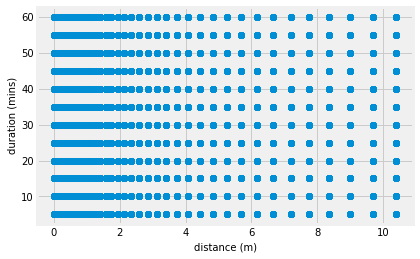

In [ ]:
data = make_input_data_train()
plt.figure()
plt.scatter(data['distance_grid'], data['duration_grid'])
plt.xlabel('distance (m)')
plt.ylabel('duration (mins)')

distances = data['distances']
durations = data['durations']
symptoms = data['symptoms']
print('{} distances, {}'.format(len(distances), distances))
print('{} durations, {}'.format(len(durations), durations))
print('{} symptoms, {}'.format(len(symptoms), symptoms))
n = len(data['distance_grid'])
print('{} x {} x {} = {}'.format(len(distances), len(durations), len(symptoms), n))

Plot grid of distance, duration and day of symptom onset.

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
distance = data['distance_grid']
duration = data['duration_grid']
onset = data['symptom_grid']
#ps = prob_infection_batch([], duration, onset, params, distance)
#ax.scatter(distance, duration, onset, c=ps)
ax.scatter(distance, duration, onset)
ax.set_xlabel('distance (m)')
ax.set_ylabel('duration (min)')
ax.set_zlabel('onset (day)')
#plt.colorbar()
ax.view_init(elev=10., azim=30)

### Test

Generate data.

In [ ]:
# Data
data_test = make_input_data_test(is_random=True)
params = ModelParams()
y_test = prob_infection_grid(data_test, params)

# Data for SGD training
ble_params = BleParams()
rssi = atten_to_rssi(data_test['atten_grid'], ble_params)
duration = data_test['duration_grid']
symptom_day = data_test['symptom_grid']
infectious = days_to_inf_levels(symptom_day)
X_test = np.concatenate([rssi[:,None], duration[:,None], infectious[:,None]], axis=1)
y_labels_test = scipy.stats.bernoulli.rvs(y_test)

# Number of true positives and true negatives
print("positives: {}, negatives: {}".format(np.sum(y_labels_test), np.sum(1-y_labels_test)))

positives: 82, negatives: 12518


In [ ]:
# Data
np.random.seed(83112)
data_random = make_input_data_test()
params = ModelParams()
y_random = prob_infection_grid(data_random, params)

# Data for SGD training
ble_params = BleParams()
rssi = atten_to_rssi(data_random['atten_grid'], ble_params)
duration = data_random['duration_grid']
symptom_day = data_random['symptom_grid']
infectious = days_to_inf_levels(symptom_day)
X_random = np.concatenate([rssi[:,None], duration[:,None], infectious[:,None]], axis=1)
y_labels_random = scipy.stats.bernoulli.rvs(y_random)

# Number of true positives and true negatives
print("positives: {}, negatives: {}".format(np.sum(y_labels_random), np.sum(1-y_labels_random)))

positives: 38, negatives: 12562


## Plot loss

### Loss by attenuation weights

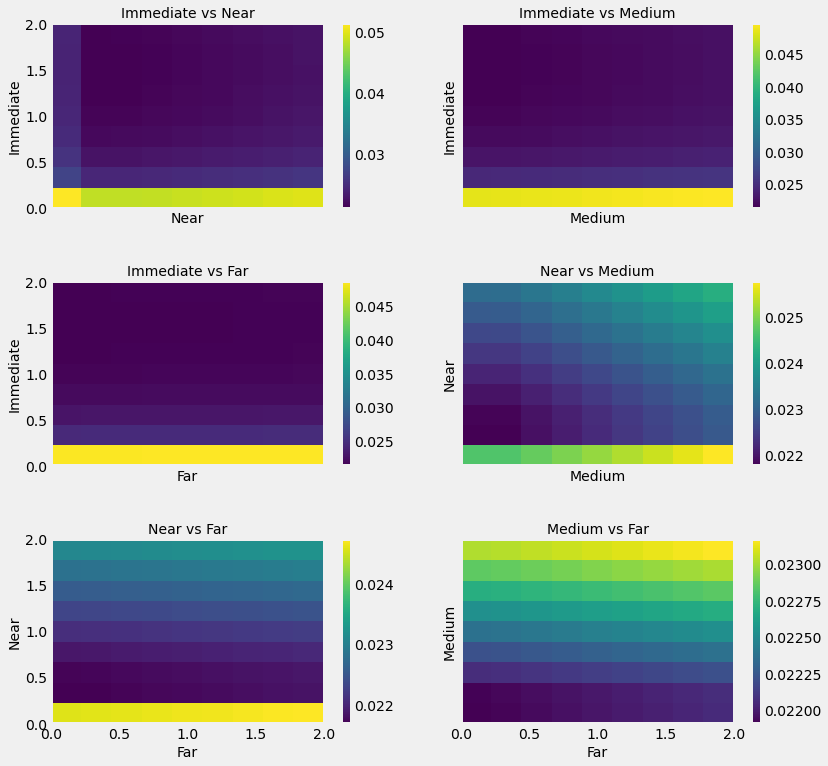

In [ ]:
config = config_baseline
w_atten_baseline = config.ble_weights
drop = np.array([0])
w_atten_vals = np.linspace(0, 2, 10)
vals = itertools.product(w_atten_vals, w_atten_vals)
w_atten_grid = np.vstack([np.array(v) for v in vals])

placement_iters = itertools.combinations(range(4), 2)
placement_perms = np.vstack([np.array(v) for v in placement_iters])

fig, axs = plt.subplots(3,2, figsize=(12,12), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.4)
axs = np.reshape(axs, (6,))
plt.style.use('seaborn-colorblind')
for i, perm in enumerate(placement_perms):
  loss = []
  levels, weights = make_infectiousness_params_v2()
  thresholds, ble_weights = make_ble_params_v2()
  config = RiskConfig(ble_thresholds = thresholds,
                              ble_weights = ble_weights,
                              inf_weights = weights,
                              inf_levels = levels,
                              name = 'Baseline')
  for w_atten in w_atten_grid:
    config.ble_weights[perm] = w_atten
    loss.append(compute_loss_from_config(config, data, y))
  xx, yy = np.meshgrid(w_atten_vals, w_atten_vals) 
  loss_array = np.reshape(loss, xx.shape)
  ax = axs[i]
  points = ax.pcolormesh(xx, yy, loss_array)
  fig.colorbar(points, ax=ax)
  
  level_names = []
  for level in perm.T:
    if level == 0:
      level_name = 'Immediate'
    elif level == 1:
      level_name = 'Near'
    elif level == 2:
      level_name = 'Medium'
    elif level == 3:
      level_name = 'Far'
    level_names.append(level_name)

  ax.set_title('{} vs {}'.format(level_names[0], level_names[1]))
  ax.set_xlabel(level_names[1])
  ax.set_ylabel(level_names[0])

### Loss by infectiousness weights

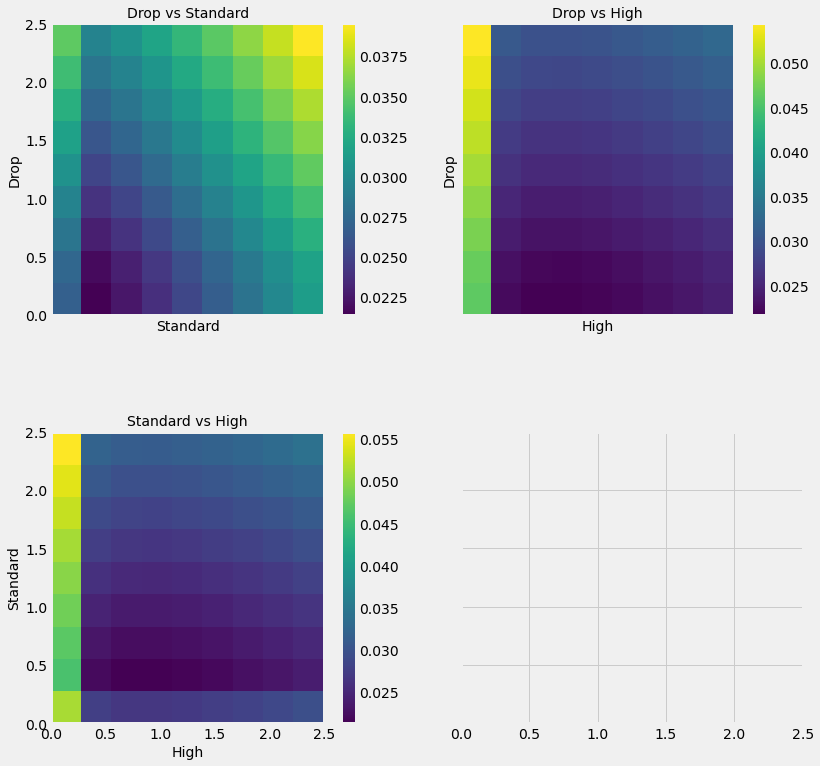

In [ ]:
w_atten_baseline = config.ble_weights
drop = np.array([0])
w_inf_vals = np.linspace(0, 2.5, 10)
vals = itertools.product(w_inf_vals, w_inf_vals)
w_inf_grid = np.vstack([np.array(v) for v in vals])

placement_iters = itertools.combinations(range(3), 2)
placement_perms = np.vstack([np.array(v) for v in placement_iters])

fig, axs = plt.subplots(2,2, figsize=(12,12), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.4)
axs = np.reshape(axs, (4,))
for i, perm in enumerate(placement_perms):
  loss = []
  levels, weights = make_infectiousness_params_v2()
  thresholds, ble_weights = make_ble_params_v2()
  config = RiskConfig(ble_thresholds = thresholds,
                              ble_weights = ble_weights,
                              inf_weights = weights,
                              inf_levels = levels,
                              name = 'Baseline')
  for w_inf in w_inf_grid:
    config.inf_weights[perm] = w_inf
    loss.append(compute_loss_from_config(config, data, y))
  xx, yy = np.meshgrid(w_inf_vals, w_inf_vals) 
  loss_array = np.reshape(loss, xx.shape)
  ax = axs[i]
  points = ax.pcolormesh(xx, yy, loss_array)
  fig.colorbar(points, ax=ax)
  
  level_names = []
  for level in perm.T:
    if level == 0:
      level_name = 'Drop'
    elif level == 1:
      level_name = 'Standard'
    elif level == 2:
      level_name = 'High'
    level_names.append(level_name)

  ax.set_title('{} vs {}'.format(level_names[0], level_names[1]))
  ax.set_xlabel(level_names[1])
  ax.set_ylabel(level_names[0])

## Test training functions

Test that the training routines reduce loss when we assume that the ground truth model is identical to the risk model we are trying to fit.

### Generate test data

In [ ]:
# Define true parameters
config_true = RiskConfig(
  ble_thresholds=np.array([-80,-70,-50]),
  ble_weights=np.array([1., 2., 5., 10.]),
  inf_weights=[0., 2., 10.],
  name='debug',
  beta=5e-03
)

# Generate demo input data using true parameters
N = 2000
rssi = np.random.rand(N)*70 - 100
duration = np.random.rand(N) * 5 + 1
infectiousness = np.random.randint(low=0,high=N_INFECT_LEVELS,size=N)
X_demo = np.concatenate([rssi[:,None], duration[:,None], infectiousness[:,None]], axis=1)

# Generate demo labels using true parameters
parameters_true = [config_true.beta,] + list(config_true.ble_weights) + list(config_true.ble_thresholds) + list(config_true.inf_weights)
parameters_true_res = get_residual_parameters(parameters_true)
probabilities_true = prob_infected_step_v(X_demo, parameters_true_res)
y_demo = scipy.stats.bernoulli.rvs(probabilities_true)

# True positives and true negatives
print("positives: {}, negatives: {}".format(np.sum(y_demo), np.sum(1-y_demo)))

positives: 414, negatives: 1586


### SGD (unknown thresholds)

In [ ]:
best_loss = np.inf
best_model_params = [np.nan] * MODEL_DIM
for i in range(2):
  print('\n----------- Training run {}/{} ----------------'.format(i+1, 2))
  model_params, loss_step_windows, probs, sigmoid_temp = train_temp(
      X_demo,
      y_demo,
      sigmoid_temp_init=0.1,
      sigmoid_temp_target=1,
      rssi_th_init=config_true.ble_thresholds + np.random.randint(low=-10,high=10,size=3),
      # rssi_th_init=[-86.,-64.,-55.],
      opt_type='gd',
      hessian_reg=0.01,
      batch_size=500,
      num_iters=5000,
      lr=0.01)
  if loss_step_windows < best_loss:
    best_loss = loss_step_windows
    best_model_params = model_params
  print ("residual parameters:")
  print_params(np.array((model_params)))
  print ("scoring parameters:")
  print_params(np.array(get_scoring_parameters(model_params)))

loss_step_windows = best_loss
# print ("residual parameters:")
# print_params(best_model_params)
print ("best scoring parameters:")
print_params(np.array(get_scoring_parameters(best_model_params)))

# loss with learned and true parameters
print ("final loss w/ learned parameters: {:.4f}".format(loss_step_windows))
loss_stepbins_func = partial(loss_fn_stepbins_ce, return_aux=False)
loss_stepbins_func_jit = jax.jit(loss_stepbins_func, static_argnums=())
loss_stepbins_true = loss_stepbins_func_jit(parameters_true_res, X_demo, y_demo)
print ("final loss w/ true parameters: {:.4f}".format(loss_stepbins_true))



----------- Training run 1/2 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.009, 0.002, 0.006, 0.006]
	rssi_th: [14.0, 20.0, 20.0]
	infectiousness: [0.01, 0.0, 0.01]
scoring:
	beta: 0.100000
	rssi_w: [0.009, 0.011, 0.017, 0.023]
	rssi_th: [-86.0, -66.0, -46.0]
	infectiousness: [0.01, 0.01, 0.02]
loss at init: sigmoid 1.9077779054641724 / step 1.922587275505066
Iter 0: batch loss 2.1813, sigmoid_temp 0.100, elapsed time 1.73
Iter 0, full train loss: step-bins 0.5954, loss sigmoid-bins 0.5860
Iter 500: batch loss 0.3311, sigmoid_temp 0.100, elapsed time 1.68
Iter 500, full train loss: step-bins 0.3197, loss sigmoid-bins 0.3208
Iter 1000: batch loss 0.3207, sigmoid_temp 0.100, elapsed time 1.66
Iter 1000, full train loss: step-bins 0.3267, loss sigmoid-bins 0.3113
Iter 1500: batch loss 0.3178, sigmoid_temp 0.100, elapsed time 1.63
Iter 1500, full train loss: step-bins 0.3591, loss sigmoid-bins 0.3095
Iter 2000: batch loss 0.3170, sigmoid_temp 0.100, elapsed ti

### SGD (known thresholds)

In [ ]:
# Train
best_loss = np.inf
for i in range(2):
  print('\n----------- Training run {}/{} ----------------'.format(i+1, 2))
  model_params, loss_step_windows, probs = train_step(
      X_demo,
      y_demo,
      # rssi_th=config_true.ble_thresholds,
      rssi_th=config_true.ble_thresholds + np.random.randint(low=-10,high=10,size=3),
      batch_size=500,
      num_iters=3000,
      lr=0.01)
  if loss_step_windows < best_loss:
    best_loss = loss_step_windows
    best_model_params = model_params

loss_step_windows = best_loss
print ("residual parameters:")
print_params(model_params)
print ("scoring parameters:")
print_params(np.array(get_scoring_parameters(model_params)))

# Loss with learned and true parameters
print ("final loss w/ learned parameters: {:.4f}".format(loss_step_windows))
print ("final loss w/ true parameters: {:.4f}".format(loss_stepbins_true))


----------- Training run 1/2 ----------------
Parameters at init:
	beta: 0.100000
	rssi_w: [0.007, 0.017, 0.027, 0.034]
	rssi_th: [-88.0, -76.0, -50.0]
	infectiousness: [0.0, 0.01, 0.01]
loss at init: 1.9765739440917969


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[array(seq)]` instead of `arr[seq]`. In the future this will result in a TypeError. See https://github.com/google/jax/issues/4564 for discussion of why this type of indexing is being deprecated.


Iter 0: loss 2.2555, elapsed time 0.94
Iter 500: loss 0.3218, elapsed time 2.36
Iter 1000: loss 0.3121, elapsed time 2.32
Iter 1500: loss 0.3099, elapsed time 2.37
Iter 2000: loss 0.3095, elapsed time 2.30
Iter 2500: loss 0.3094, elapsed time 2.32
Iter 2999: loss 0.3176, elapsed time 2.39
loss at the end: step-bins 0.2998

----------- Training run 2/2 ----------------
Parameters at init:
	beta: 0.100000
	rssi_w: [0.007, 0.009, 0.013, 0.019]
	rssi_th: [-80.0, -69.0, -44.0]
	infectiousness: [0.01, 0.01, 0.02]
loss at init: 1.9690148830413818
Iter 0: loss 2.2504, elapsed time 0.88
Iter 500: loss 0.3204, elapsed time 2.38
Iter 1000: loss 0.3165, elapsed time 2.47
Iter 1500: loss 0.3157, elapsed time 2.47
Iter 2000: loss 0.3153, elapsed time 2.51
Iter 2500: loss 0.3153, elapsed time 2.41
Iter 2999: loss 0.3273, elapsed time 2.30
loss at the end: step-bins 0.3068
residual parameters:
	beta: 0.510819
	rssi_w: [0.135, 0.248, 0.436, 0.242]
	rssi_th: [20.0, 11.0, 25.0]
	infectiousness: [0.0, 0.1

## Example use

### SGD (unknown thresholds)

Train with soft labels.

In [ ]:
best_loss = np.inf
best_model_params = [np.nan] * MODEL_DIM
model_params_list_temp = []
for i in range(N_RESTARTS):
  print('----------- Training run {}/{} --------------'.format(i+1, N_RESTARTS))
  model_params, loss_step_windows, probs_est, sigmoid_temp = train_temp(
      X,
      y,
      sigmoid_temp_init=0.1,
      sigmoid_temp_target=1,
      rssi_th_init=None,
      # rssi_th_init=[-86.,-64.,-55.],
      opt_type='gd',
      hessian_reg=0.01,
      batch_size=500,
      num_iters=5000,
      lr=0.001)
  model_params_list_temp.append(model_params)
  if loss_step_windows < best_loss:
    best_loss = loss_step_windows
    best_model_params = model_params
    best_probs = probs_est
  print ("residual parameters:")
  print_params(np.array((model_params)))
  print ("scoring parameters:")
  print_params(np.array(get_scoring_parameters(model_params)))

loss_step_windows = best_loss
# print ("residual parameters:")
# print_params(best_model_params)
print ("best scoring parameters:")
print_params(np.array(get_scoring_parameters(best_model_params)))

# Loss with learned and true parameters
print ("final loss w/ learned parameters: {:.4f}".format(loss_step_windows))
loss_true = loss_fn_ce_probs(y, y_labels)
print ("final loss w/ true parameters: {:.4f}".format(loss_true))

# Learned config
config_sgd_temp = model_params_to_config_sgd(best_model_params)
config_sgd_temp.name = 'SGD_temp'

----------- Training run 1/2 --------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.004, 0.008, 0.001, 0.003]
	rssi_th: [16.0, 15.0, 23.0]
	infectiousness: [0.01, 0.01, 0.0]
scoring:
	beta: 0.100000
	rssi_w: [0.004, 0.012, 0.013, 0.015]
	rssi_th: [-84.0, -69.0, -46.0]
	infectiousness: [0.01, 0.01, 0.01]
loss at init: sigmoid 0.027565455064177513 / step 0.027607515454292297
Iter 0: batch loss 0.0250, sigmoid_temp 0.100, elapsed time 1.66
Iter 0, full train loss: step-bins 0.0273, loss sigmoid-bins 0.0273
Iter 500: batch loss 0.0052, sigmoid_temp 0.100, elapsed time 1.78
Iter 500, full train loss: step-bins 0.0217, loss sigmoid-bins 0.0218
Iter 1000: batch loss 0.0244, sigmoid_temp 0.100, elapsed time 1.82
Iter 1000, full train loss: step-bins 0.0213, loss sigmoid-bins 0.0214
Iter 1500: batch loss 0.0192, sigmoid_temp 0.100, elapsed time 1.62
Iter 1500, full train loss: step-bins 0.0211, loss sigmoid-bins 0.0212
Iter 2000: batch loss 0.0266, sigmoid_temp 0.100, elapsed 

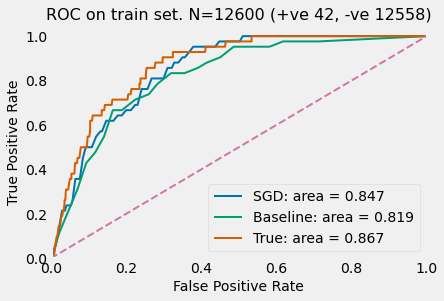

[0.8468733647305076, 0.8185220576524925, 0.8669298265571558]

In [ ]:
# Baseline parameters
base_params_res = config_to_model_params_sgd(config_baseline)
base_probs = prob_infected_step_v(X, base_params_res)

# Plot ROC
N_pos = np.sum(y_labels)
N_neg = np.sum(1-y_labels)
N = X.shape[0]
title = 'ROC on train set. N={} (+ve {}, -ve {})'.format(N, N_pos, N_neg)
probs = [best_probs, base_probs, y]
plot_roc(probs, y_labels, ['SGD', 'Baseline', 'True'], title)

Train with hard labels.

In [ ]:
best_loss = np.inf
best_model_params = [np.nan] * MODEL_DIM
model_params_list_temp_hard = []
for i in range(N_RESTARTS):
  print('----------- Training run {}/{} --------------'.format(i+1, N_RESTARTS))
  model_params, loss_step_windows, probs_est, sigmoid_temp = train_temp(X,
            y_labels,
            sigmoid_temp_init=0.1,
            sigmoid_temp_target=1,
            rssi_th_init=None,
            # rssi_th_init=[-86.,-64.,-55.],
            opt_type='gd',
            hessian_reg=0.01,
            batch_size=500,
            num_iters=5000,
            lr=0.001)
  model_params_list_temp_hard.append(model_params)
  if loss_step_windows < best_loss:
    best_loss = loss_step_windows
    best_model_params = model_params
    best_probs = probs_est
  print ("residual parameters:")
  print_params(np.array((model_params)))
  print ("scoring parameters:")
  print_params(np.array(get_scoring_parameters(model_params)))

loss_step_windows = best_loss
# print ("residual parameters:")
# print_params(best_model_params)
print ("best scoring parameters:")
print_params(np.array(get_scoring_parameters(best_model_params)))

# Loss with learned and true parameters
print ("final loss w/ learned parameters: {:.4f}".format(loss_step_windows))
loss_true = loss_fn_ce_probs(y, y_labels)
print ("final loss w/ true parameters: {:.4f}".format(loss_true))

# Learned config
config_sgd_temp_hard = model_params_to_config_sgd(best_model_params)
config_sgd_temp_hard.name = 'SGD_temp_hard'

----------- Training run 1/2 --------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.008, 0.001, 0.003, 0.006]
	rssi_th: [12.0, 20.0, 14.0]
	infectiousness: [0.0, 0.0, 0.0]
scoring:
	beta: 0.100000
	rssi_w: [0.008, 0.009, 0.012, 0.019]
	rssi_th: [-88.0, -68.0, -54.0]
	infectiousness: [0.0, 0.01, 0.01]
loss at init: sigmoid 0.025285985320806503 / step 0.025291819125413895
Iter 0: batch loss 0.0294, sigmoid_temp 0.100, elapsed time 1.70
Iter 0, full train loss: step-bins 0.0248, loss sigmoid-bins 0.0248
Iter 500: batch loss 0.0023, sigmoid_temp 0.100, elapsed time 1.59
Iter 500, full train loss: step-bins 0.0197, loss sigmoid-bins 0.0198
Iter 1000: batch loss 0.0152, sigmoid_temp 0.100, elapsed time 1.69
Iter 1000, full train loss: step-bins 0.0194, loss sigmoid-bins 0.0196
Iter 1500: batch loss 0.0216, sigmoid_temp 0.100, elapsed time 1.62
Iter 1500, full train loss: step-bins 0.0193, loss sigmoid-bins 0.0195
Iter 2000: batch loss 0.0036, sigmoid_temp 0.100, elapsed tim

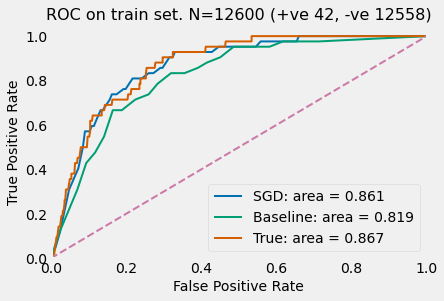

[0.8610561281368735, 0.8185220576524925, 0.8669298265571558]

In [ ]:
# Baseline parameters
base_params_res = config_to_model_params_sgd(config_baseline)
base_probs = prob_infected_step_v(X, base_params_res)

# Plot ROC
N_pos = np.sum(y_labels)
N_neg = np.sum(1-y_labels)
N = X.shape[0]
title = 'ROC on train set. N={} (+ve {}, -ve {})'.format(N, N_pos, N_neg)
probs = [best_probs, base_probs, y]
plot_roc(probs, y_labels, ['SGD', 'Baseline', 'True'], title)

Train using gradient descent (instead of batch gradient descent).

In [ ]:
best_loss = np.inf
best_model_params = [np.nan] * MODEL_DIM
model_params_list_temp_gd = []
for i in range(N_RESTARTS):
  print('----------- Training run {}/{} --------------'.format(i+1, N_RESTARTS))
  model_params, loss_step_windows, probs_est, sigmoid_temp = train_temp(
      X,
      y,
      sigmoid_temp_init=0.1,
      sigmoid_temp_target=1,
      rssi_th_init=None,
      # rssi_th_init=[-86.,-64.,-55.],
      opt_type='gd',
      hessian_reg=0.01,
      batch_size=len(X),
      num_iters=5000,
      lr=0.001)
  model_params_list_temp_gd.append(model_params)
  if loss_step_windows < best_loss:
    best_loss = loss_step_windows
    best_model_params = model_params
    best_probs = probs_est
  print ("residual parameters:")
  print_params(np.array((model_params)))
  print ("scoring parameters:")
  print_params(np.array(get_scoring_parameters(model_params)))

loss_step_windows = best_loss
# print ("residual parameters:")
# print_params(best_model_params)
print ("best scoring parameters:")
print_params(np.array(get_scoring_parameters(best_model_params)))

# Loss with learned and true parameters
print ("final loss w/ learned parameters: {:.4f}".format(loss_step_windows))
loss_true = loss_fn_ce_probs(y, y_labels)
print ("final loss w/ true parameters: {:.4f}".format(loss_true))

# Learned config
config_gd_temp = model_params_to_config_sgd(best_model_params)
config_gd_temp.name = 'GD_temp'

----------- Training run 1/2 --------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.003, 0.008, 0.01, 0.004]
	rssi_th: [20.0, 28.0, 11.0]
	infectiousness: [0.0, 0.01, 0.0]
scoring:
	beta: 0.100000
	rssi_w: [0.003, 0.011, 0.021, 0.025]
	rssi_th: [-80.0, -52.0, -41.0]
	infectiousness: [0.0, 0.01, 0.02]
loss at init: sigmoid 0.025210311636328697 / step 0.02531261369585991
Iter 0: batch loss 0.0252, sigmoid_temp 0.100, elapsed time 2.43
Iter 0, full train loss: step-bins 0.0252, loss sigmoid-bins 0.0251
Iter 500: batch loss 0.0215, sigmoid_temp 0.100, elapsed time 2.20
Iter 500, full train loss: step-bins 0.0214, loss sigmoid-bins 0.0215
Iter 1000: batch loss 0.0212, sigmoid_temp 0.100, elapsed time 2.45
Iter 1000, full train loss: step-bins 0.0211, loss sigmoid-bins 0.0212
Iter 1500: batch loss 0.0210, sigmoid_temp 0.100, elapsed time 2.45
Iter 1500, full train loss: step-bins 0.0209, loss sigmoid-bins 0.0210
Iter 2000: batch loss 0.0209, sigmoid_temp 0.100, elapsed time

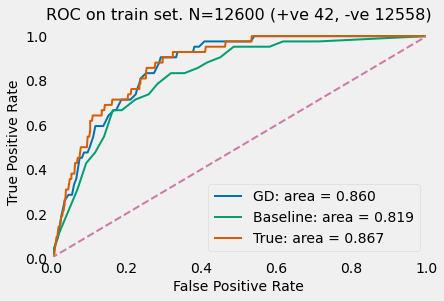

[0.8604532113848884, 0.8185220576524925, 0.8669298265571558]

In [ ]:
# Baseline parameters
base_params_res = config_to_model_params_sgd(config_baseline)
base_probs = prob_infected_step_v(X, base_params_res)

# Plot ROC
N_pos = np.sum(y_labels)
N_neg = np.sum(1-y_labels)
N = X.shape[0]
title = 'ROC on train set. N={} (+ve {}, -ve {})'.format(N, N_pos, N_neg)
probs = [best_probs, base_probs, y]
plot_roc(probs, y_labels, ['GD', 'Baseline', 'True'], title)

### SGD (known thresholds)

Train with soft labels.

In [ ]:
# with step buckets (fixed rssi thresholds)
best_loss = np.inf
model_params_list_step = []
for i in range(N_RESTARTS):
  print('----------- Training run {}/{} ----------------'.format(i, N_RESTARTS))
  model_params, loss_step_windows, probs = train_step(
      X,
      y,
      # rssi_th=config_true.ble_thresholds,
      rssi_th=None,
      batch_size=500,
      num_iters=3000,
      lr=0.001)
  model_params_list_step.append(model_params)
  if loss_step_windows < best_loss:
    best_loss = loss_step_windows
    best_model_params = model_params
    best_probs = probs_est

loss_step_windows = best_loss
print ("residual parameters:")
print_params(model_params)
print ("scoring parameters:")
print_params(np.array(get_scoring_parameters(model_params)))

# loss with learned and true parameters
print ("final loss w/ learned parameters: {:.4f}".format(loss_step_windows))
loss_true = loss_fn_ce_probs(y, y_labels)
print ("final loss w/ true parameters: {:.4f}".format(loss_true))

# Learned config
config_sgd_step = model_params_to_config_sgd(best_model_params)
config_sgd_step.name = 'SGD_step'

----------- Training run 0/2 ----------------
Parameters at init:
	beta: 0.100000
	rssi_w: [0.008, 0.018, 0.024, 0.027]
	rssi_th: [-86.0, -69.0, -47.0]
	infectiousness: [0.0, 0.0, 0.01]
loss at init: 0.026556720957159996


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[array(seq)]` instead of `arr[seq]`. In the future this will result in a TypeError. See https://github.com/google/jax/issues/4564 for discussion of why this type of indexing is being deprecated.


Iter 0: loss 0.0241, elapsed time 0.95
Iter 500: loss 0.0053, elapsed time 2.53
Iter 1000: loss 0.0241, elapsed time 2.49
Iter 1500: loss 0.0194, elapsed time 2.43
Iter 2000: loss 0.0263, elapsed time 2.35
Iter 2500: loss 0.0240, elapsed time 2.44
Iter 2999: loss 0.0131, elapsed time 2.41
loss at the end: step-bins 0.0210
----------- Training run 1/2 ----------------
Parameters at init:
	beta: 0.100000
	rssi_w: [0.002, 0.006, 0.014, 0.019]
	rssi_th: [-78.0, -67.0, -40.0]
	infectiousness: [0.0, 0.0, 0.01]
loss at init: 0.028164347633719444
Iter 0: loss 0.0251, elapsed time 0.92
Iter 500: loss 0.0048, elapsed time 2.52
Iter 1000: loss 0.0246, elapsed time 2.49
Iter 1500: loss 0.0194, elapsed time 2.49
Iter 2000: loss 0.0268, elapsed time 2.48
Iter 2500: loss 0.0239, elapsed time 2.46
Iter 2999: loss 0.0128, elapsed time 2.52
loss at the end: step-bins 0.0210
residual parameters:
	beta: 0.108504
	rssi_w: [0.001, 0.011, 0.035, 0.023]
	rssi_th: [22.0, 11.0, 27.0]
	infectiousness: [0.0, 0.01

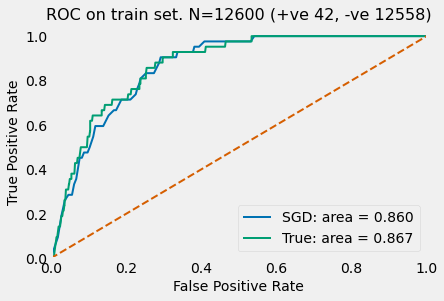

[0.8604532113848884, 0.8669298265571558]

In [ ]:
# Plot ROC
title = 'ROC on train set. N={} (+ve {}, -ve {})'.format(N, N_pos, N_neg)
plot_roc([best_probs, y], y_labels, ['SGD', 'True'], title)

Train with hard labels.

In [ ]:
# with step buckets (fixed rssi thresholds)
best_loss = np.inf
model_params_list_step_hard = []
for i in range(N_RESTARTS):
  print('----------- Training run {}/{} ----------------'.format(i, N_RESTARTS))
  model_params, loss_step_windows, probs = train_step(
      X,
      y_labels,
      # rssi_th=config_true.ble_thresholds,
      rssi_th=None,
      batch_size=500,
      num_iters=3000,
      lr=0.001)
  model_params_list_step_hard.append(model_params)
  if loss_step_windows < best_loss:
    best_loss = loss_step_windows
    best_model_params = model_params
    best_probs = probs_est

loss_step_windows = best_loss
print ("residual parameters:")
print_params(model_params)
print ("scoring parameters:")
print_params(np.array(get_scoring_parameters(model_params)))

# loss with learned and true parameters
print ("final loss w/ learned parameters: {:.4f}".format(loss_step_windows))
loss_true = loss_fn_ce_probs(y, y_labels)
print ("final loss w/ true parameters: {:.4f}".format(loss_true))

# Learned config
config_sgd_step_hard = model_params_to_config_sgd(best_model_params)
config_sgd_step_hard.name = 'SGD_step_hard'

----------- Training run 0/2 ----------------
Parameters at init:
	beta: 0.100000
	rssi_w: [0.0, 0.002, 0.012, 0.014]
	rssi_th: [-72.0, -44.0, -23.0]
	infectiousness: [0.01, 0.01, 0.01]
loss at init: 0.02684652991592884


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[array(seq)]` instead of `arr[seq]`. In the future this will result in a TypeError. See https://github.com/google/jax/issues/4564 for discussion of why this type of indexing is being deprecated.


Iter 0: loss 0.0287, elapsed time 1.04
Iter 500: loss 0.0019, elapsed time 2.82
Iter 1000: loss 0.0147, elapsed time 2.84
Iter 1500: loss 0.0223, elapsed time 2.85
Iter 2000: loss 0.0029, elapsed time 2.50
Iter 2500: loss 0.0121, elapsed time 2.43
Iter 2999: loss 0.0203, elapsed time 2.33
loss at the end: step-bins 0.0191
----------- Training run 1/2 ----------------
Parameters at init:
	beta: 0.100000
	rssi_w: [0.002, 0.003, 0.004, 0.012]
	rssi_th: [-74.0, -64.0, -42.0]
	infectiousness: [0.01, 0.01, 0.02]
loss at init: 0.02604634128510952
Iter 0: loss 0.0290, elapsed time 0.92
Iter 500: loss 0.0016, elapsed time 2.48
Iter 1000: loss 0.0152, elapsed time 2.50
Iter 1500: loss 0.0220, elapsed time 2.45
Iter 2000: loss 0.0034, elapsed time 2.52
Iter 2500: loss 0.0118, elapsed time 2.48
Iter 2999: loss 0.0207, elapsed time 2.50
loss at the end: step-bins 0.0192
residual parameters:
	beta: 0.106331
	rssi_w: [0.005, 0.021, 0.018, 0.025]
	rssi_th: [26.0, 10.0, 22.0]
	infectiousness: [0.0, 0.0

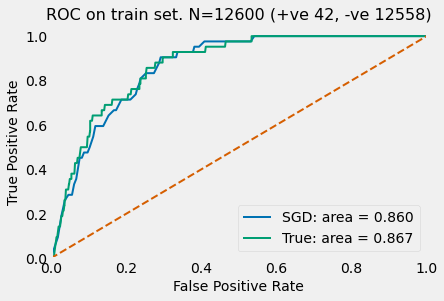

[0.8604532113848884, 0.8669298265571558]

In [ ]:
# Plot ROC
title = 'ROC on train set. N={} (+ve {}, -ve {})'.format(N, N_pos, N_neg)
plot_roc([best_probs, y], y_labels, ['SGD', 'True'], title)

### SQP (known thresholds)

Train with soft labels (i.e. probabilities)after initializing from a specific config.

In [ ]:
# Define output config (empty parameters are to be learned)
out_config = RiskConfig(
    ble_thresholds = jnp.array([50., 70., 80.]),
    inf_levels = make_infectiousness_params_v2()[0],
    beta = 3.1 * 1e-4,  # Wilson table 1 (divide by 100)
    name = 'SQP'
)

# Initialize parameters
model_params = config_to_model_params(config_baseline)
model_params = np.clip(model_params, 0.01, 100)  # 0.01 is the min on ENS
config_random = model_params_to_config(model_params, out_config)
print('Init config:\n\n{}\n'.format(config_random))

#Initial loss
np.random.seed(42148)
true_loss = ce_loss(y_labels, y)
init_loss = compute_loss_from_config(config_random, data, y)
init_loss_true = compute_loss_from_config(config_random, data, y_labels)
losses = (true_loss, init_loss, init_loss_true)
print('True loss = %.5f\nInit loss = %.5f\nInit loss (true) = %.5f\n' % losses)

# Optimize with constraints
opt, cache = train_with_optimizer(
  compute_loss_and_grad,
  model_params, 
  args=(config_random.ble_thresholds, data, y), 
  method='SLSQP',
  tol=1e-6  # any less appears to significantly underperform
)

# Print optimization output
print(opt)

# Print learned configuration
config_sqp = model_params_to_config(opt.x, out_config)
print(config_sqp)

# Compare losses
y_hat = prob_risk_score_grid(data, config_sqp)
learned_loss = ce_loss(y, y_hat)
learned_loss_true = ce_loss(y_labels, y_hat)
losses = (learned_loss, learned_loss_true)
print('\nLearned loss = %.5f\nLearned loss (true) = %.5f' % losses)

True loss = 0.01910
Init loss = 0.02146
Init loss (true) = 0.02030

     fun: 0.020582430064678192
     jac: array([ 4.48229221e-05,  2.99751526e-04, -5.06042161e-05, -2.44852490e-05,
       -7.52908090e-05, -9.85019433e-05,  2.76574399e-04])
 message: 'Optimization terminated successfully.'
    nfev: 15
     nit: 13
    njev: 13
  status: 0
 success: True
       x: array([1.94548684, 0.5287904 , 0.03362725, 0.01313255, 0.02163646,
       0.16195407, 0.9446527 ])
RiskConfig(ble_thresholds=DeviceArray([50., 70., 80.], dtype=float32), ble_weights=array([1.94548684, 0.5287904 , 0.03362725, 0.01313255]), inf_levels=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0]), inf_weights=array([0.02163646, 0.16195407, 0.9446527 ]), name='SQP', beta=0.00031)

Learned loss = 0.02058
Learned loss (true) = 0.01926


In [ ]:
# Parameter trajectory
param_names = ['Immediate', 'Near', 'Medium', 'Far', 'Drop', 'Standard', 'High']
trajectories = np.array(cache).T
n = trajectories.shape[1]
x = np.arange(0, n, 1)

# Plot
fig, axs = plt.subplots(4,2, figsize=(12,16), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.4)
axs = np.reshape(axs, (8,))
for i, trajectory in enumerate(trajectories):
  ax = axs[i]
  ax.plot(x, trajectory, 'o-')
  ax.set_title('{}'.format(param_names[i]))
  ax.set_xlabel('Iteration')
  ax.set_ylabel('Value')

Text(0, 0.5, 'Cross-entropy loss')

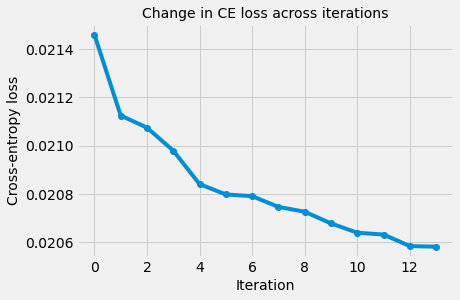

In [ ]:
# Loss trajectory
losses = []
for iter_params in cache:
  loss = compute_loss(iter_params, config_random.ble_thresholds, data, y)
  losses.append(loss)

# Plot
iters = np.arange(len(losses))
plt.plot(iters, losses, 'o-')
plt.title('Change in CE loss across iterations')
plt.xlabel('Iteration')
plt.ylabel('Cross-entropy loss')

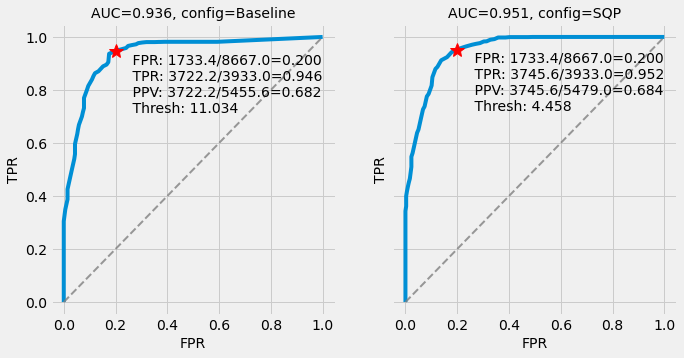

In [ ]:
# ROC curve
config_list = [config_baseline, config_sqp]
np.random.seed(42148)
plot_ROC_curves(data, params, config_list, target_fpr=0.2)

Train with hard labels (i.e. ones or zeros)after initializing from a specific config.

In [ ]:
# Define output config (empty parameters are to be learned)
out_config = RiskConfig(
    ble_thresholds = jnp.array([50., 70., 80.]),
    inf_levels = make_infectiousness_params_v2()[0],
    beta = 3.1 * 1e-4,  # Wilson table 1 (divide by 100)
    name = 'SQP'
)

# Initialize parameters
model_params = config_to_model_params(config_baseline)
model_params = np.clip(model_params, 0.01, 100)  # 0.01 is the min on ENS
config_random = model_params_to_config(model_params, out_config)
print('Init config:\n\n{}\n'.format(config_random))

#Initial loss
np.random.seed(42148)
true_loss = ce_loss(y_labels, y)
init_loss =  compute_loss_from_config(config_baseline, data, y)
y_hat = prob_risk_score_grid(data, config_baseline)
init_loss_true = ce_loss(y_labels, y_hat)
losses = (true_loss, init_loss, init_loss_true)
print('True loss = %.5f\nInit loss = %.5f\nInit loss (true) = %.5f\n' % losses)

# Optimize with constraints
opt, cache = train_with_optimizer(
  compute_loss_and_grad,
  model_params, 
  args=(config_random.ble_thresholds, data, y_labels), 
  method='SLSQP',
  tol=1e-6
)

# Print optimization output
print(opt)

# Print learned configuration
config_sqp_hard = model_params_to_config(opt.x, out_config)
print('Learned config:\n\n{}\n'.format(config_sqp_hard))

# Compare losses
y_hat = prob_risk_score_grid(data, config_sqp_hard)
learned_loss = ce_loss(y, y_hat)
learned_loss_true = ce_loss(y_labels, y_hat)
losses = (learned_loss, learned_loss_true)
print('\nLearned loss = %.5f\nLearned loss (true) = %.5f' % losses)

True loss = 0.01910
Init loss = 0.02182
Init loss (true) = 0.02073

     fun: 0.01917620375752449
     jac: array([ 2.95329897e-04, -2.79535219e-04,  0.00000000e+00,  0.00000000e+00,
        8.89235816e-05, -4.76599787e-04,  5.14408282e-04])
 message: 'Optimization terminated successfully.'
    nfev: 14
     nit: 13
    njev: 13
  status: 0
 success: True
       x: array([1.89830517, 0.59872752, 0.        , 0.        , 0.02189377,
       0.15085232, 0.89679858])
RiskConfig(ble_thresholds=DeviceArray([50., 70., 80.], dtype=float32), ble_weights=array([1.89830517, 0.59872752, 0.        , 0.        ]), inf_levels=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0]), inf_weights=array([0.02189377, 0.15085232, 0.89679858]), name='SQP_hard', beta=0.00031)

Learned loss = 0.02070
Learned loss (true) = 0.01918


Train with soft labels after initializeing with random parameters.

In [ ]:
# Define output config (empty parameters are to be learned)
out_config = RiskConfig(
    ble_thresholds = jnp.array([50., 70., 80.]),
    inf_levels = make_infectiousness_params_v2()[0],
    beta = 3.1 * 1e-4,  # Wilson table 1 (divide by 100)
    name= 'SQP_random'
)

# Initialize parameters
model_params = config_to_model_params(config_init, with_thresholds=False)
config_random = model_params_to_config(model_params, out_config)
print('Init config:\n\n{}\n'.format(config_random))

#Initial loss
np.random.seed(42148)
true_loss = ce_loss(y_labels, y)
init_loss = compute_loss_from_config(config_random, data, y)
init_loss_true = compute_loss_from_config(config_random, data, y_labels)
losses = (true_loss, init_loss, init_loss_true)
print('True loss = %.5f\nInit loss = %.5f\nInit loss (true) = %.5f\n' % losses)

# Optimize with constraints
opt, cache = train_with_optimizer(
  compute_loss_and_grad,
  model_params, 
  args=(config_random.ble_thresholds, data, y), 
  method='SLSQP',
  tol=1e-6
)

# Print optimization output
print('Optimization results:\n\n{}\n'.format(opt))

# Print learned configuration
config_sqp_random = model_params_to_config(opt.x, out_config)
print('Learned config:\n\n{}\n'.format(config_sqp_random))

# Compare losses
y_hat = prob_risk_score_grid(data, config_sqp_random)
learned_loss = ce_loss(y, y_hat)
learned_loss_true = ce_loss(y_labels, y_hat)
losses = (learned_loss, learned_loss_true)
print('\nLearned loss = %.5f\nLearned loss (true) = %.5f' % losses)

Init config:

RiskConfig(ble_thresholds=DeviceArray([50., 70., 80.], dtype=float32), ble_weights=DeviceArray([1.83, 1.27, 0.84, 0.2 ], dtype=float32), inf_levels=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0]), inf_weights=DeviceArray([0.55, 0.8 , 1.11], dtype=float32), name='SQP_random', beta=0.00031)

True loss = 0.01910
Init loss = 0.02635
Init loss (true) = 0.02481

Optimization results:

     fun: 0.02057492360472679
     jac: array([-2.66095394e-05, -6.03587323e-05,  3.36866535e-04,  5.38408276e-05,
        2.26491553e-04, -1.26914761e-04, -2.08325328e-05])
 message: 'Optimization terminated successfully.'
    nfev: 34
     nit: 32
    njev: 32
  status: 0
 success: True
       x: array([2.        , 0.39256526, 0.11182171, 0.11182171, 0.02084073,
       0.16346938, 0.86276814])

Learned config:

RiskConfig(ble_thresholds=DeviceArray([50., 70., 80.], dtype=float32), ble_weights=array([2.        , 0.39256526, 0.11182171, 0.11182

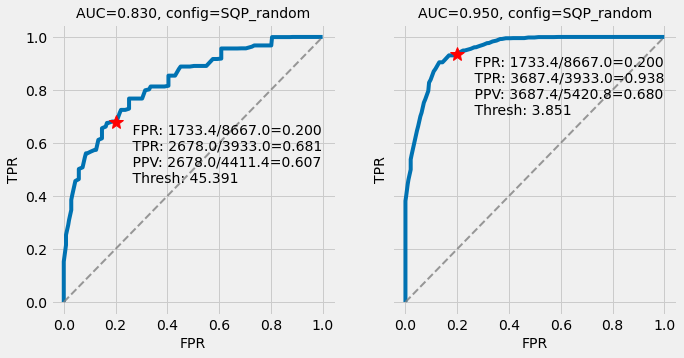

In [ ]:
# ROC curve
config_list = [config_random, config_sqp_random]
np.random.seed(42148)
plot_ROC_curves(data, params, config_list, target_fpr=0.2)

Train with soft labels and residual parameters.

In [ ]:
# Define output config (empty parameters are to be learned)
out_config = RiskConfig(
    ble_thresholds = jnp.array([50., 70., 80.]),
    inf_levels = make_infectiousness_params_v2()[0],
    beta = 3.1 * 1e-4,  # Wilson table 1 (divide by 100)
    name= 'SQP_resid'
)

# Initialize parameters
model_params = config_to_model_params(config_baseline, with_thresholds=False)
model_params = np.clip(model_params, 0.01, 100)  # 0.01 is the min on ENS
resid_params = model_params_to_resid_params(model_params)
config_random = model_params_to_config(model_params, out_config)
print('Init config:\n\n{}\n'.format(config_random))

#Initial loss
np.random.seed(42148)
true_loss = ce_loss(y_labels, y)
init_loss = compute_loss_from_config(config_random, data, y)
init_loss_true = compute_loss_from_config(config_random, data, y_labels)
losses = (true_loss, init_loss, init_loss_true)
print('True loss = %.5f\nInit loss = %.5f\nInit loss (true) = %.5f\n' % losses)

# Optimize with constraints
opt, cache = train_with_optimizer(
  compute_loss_and_grad_res,
  resid_params, 
  args=(config_random.ble_thresholds, data, y), 
  method='SLSQP',
  tol=1e-6,
  with_resids=True
)

# Print optimization output
print('Optimization results:\n\n{}\n'.format(opt))

# Print learned configuration
model_params = resid_params_to_model_params(opt.x)
config_sqp_resid = model_params_to_config(model_params, out_config)
print('Learned config:\n\n{}\n'.format(config_sqp_resid))

# Compare losses
y_hat = prob_risk_score_grid(data, config_sqp_resid)
learned_loss = ce_loss(y, y_hat)
learned_loss_true = ce_loss(y_labels, y_hat)
losses = (learned_loss, learned_loss_true)
print('\nLearned loss = %.5f\nLearned loss (true) = %.5f' % losses)

Init config:

RiskConfig(ble_thresholds=DeviceArray([50., 70., 80.], dtype=float32), ble_weights=array([2.39, 0.6 , 0.06, 0.01], dtype=float32), inf_levels=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0]), inf_weights=array([0.01      , 0.39810717, 1.        ], dtype=float32), name='SQP_resid', beta=0.00031)

True loss = 0.01910
Init loss = 0.02146
Init loss (true) = 0.02030

Optimization results:

     fun: 0.02065194398164749
     jac: array([ 3.25783476e-05,  3.15064790e-05,  0.00000000e+00,  0.00000000e+00,
       -1.20930104e-04,  1.11729260e-05,  2.30114238e-05])
 message: 'Optimization terminated successfully.'
    nfev: 18
     nit: 18
    njev: 18
  status: 0
 success: True
       x: array([ 2.        , -1.5800259 , -0.54000002, -0.05      ,  0.02139272,
        0.14435047,  0.71050889])

Learned config:

RiskConfig(ble_thresholds=DeviceArray([50., 70., 80.], dtype=float32), ble_weights=DeviceArray([ 2.        ,  0.4199741 ,

Train after initializing using the same initialization as for SGD.

In [ ]:
# Define output config (empty parameters are to be learned)
out_config = RiskConfig(
    ble_thresholds = jnp.array([50., 70., 80.]),
    inf_levels = make_infectiousness_params_v2()[0],
    beta = 3.1 * 1e-4,  # Wilson table 1 (divide by 100)
    name = 'SQP'
)

# Initialize parameters
model_params = config_to_model_params(config_baseline)
model_params = np.clip(model_params, 0.01, 100)  # 0.01 is the min on ENS
config_random = model_params_to_config(model_params, out_config)

#Initial loss
np.random.seed(42148)
true_loss = ce_loss(y_labels, y)
init_loss = compute_loss_from_config(config_random, data, y)
init_loss_true = compute_loss_from_config(config_random, data, y_labels)
losses = (true_loss, init_loss, init_loss_true)
print('True loss = %.5f\nInit loss = %.5f\nInit loss (true) = %.5f\n' % losses)

# Optimize with constraints
opt, cache = train_with_optimizer(
  compute_loss_and_grad,
  model_params, 
  args=(config_random.ble_thresholds, data, y), 
  method='SLSQP',
  tol=1e-6  # any less appears to significantly underperform
)

# Print optimization output
print(opt)

# Print learned configuration
config_sqp_sgd_init = model_params_to_config(opt.x, out_config)
print('Learned config:\n\n{}\n'.format(config_sqp_sgd_init))

# Compare losses
y_hat = prob_risk_score_grid(data, config_sqp_sgd_init)
learned_loss = ce_loss(y, y_hat)
learned_loss_true = ce_loss(y_labels, y_hat)
losses = (learned_loss, learned_loss_true)
print('\nLearned loss = %.5f\nLearned loss (true) = %.5f' % losses)

True loss = 0.01910
Init loss = 0.02146
Init loss (true) = 0.02030

     fun: 0.020582430064678192
     jac: array([ 4.48229221e-05,  2.99751526e-04, -5.06042161e-05, -2.44852490e-05,
       -7.52908090e-05, -9.85019433e-05,  2.76574399e-04])
 message: 'Optimization terminated successfully.'
    nfev: 15
     nit: 13
    njev: 13
  status: 0
 success: True
       x: array([1.94548684, 0.5287904 , 0.03362725, 0.01313255, 0.02163646,
       0.16195407, 0.9446527 ])
RiskConfig(ble_thresholds=DeviceArray([50., 70., 80.], dtype=float32), ble_weights=array([1.94548684, 0.5287904 , 0.03362725, 0.01313255]), inf_levels=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0]), inf_weights=array([0.02163646, 0.16195407, 0.9446527 ]), name='SQP', beta=0.00031)

Learned loss = 0.02058
Learned loss (true) = 0.01926


### SQP (unknown thresholds)

This is using nested optimization, where each trial uses a different random initialization.

In [ ]:
np.random.seed(180331)
true_loss = ce_loss(y_labels, y)

opts = []
caches = []
init_losses = []
final_losses = []
learned_configs = []

for i in range(N_RESTARTS):
  print('------------ Trial {}/{} ------------\n'.format(i+1, N_RESTARTS))
  # Define output config (empty parameters are to be learned)
  out_config = RiskConfig(
      inf_levels = make_infectiousness_params_v2()[0],
      beta = 3.1 * 1e-4,  # Wilson table 1 (divide by 100)
      name= 'SQP_thresh'
  )

  # Initialize parameters
  model_params = config_to_model_params(config_init, with_thresholds=False)
  out_config.ble_thresholds = np.sort(np.random.randint(40, 81, N_RSSI_TH))
  config_random = model_params_to_config(model_params, out_config)
  print('Init config:\n\n{}\n'.format(config_random))

  #Initial loss
  init_loss = compute_loss_from_config(config_random, data, y)
  init_losses.append(init_loss)
  print('Init loss = %.5f\n' % init_loss)

  # Optimize with constraints
  opt, cache = train_with_optimizer(
    compute_loss_and_grad,
    model_params, 
    args=(config_random.ble_thresholds, data, y), 
    method='SLSQP',
    tol=1e-6
  )

  opts.append(opt)
  caches.append(cache)

  # Print optimization output
  print('Optimization results:\n\n{}\n'.format(opt))

  # Print learned configuration
  config_sqp_thresh = model_params_to_config(opt.x, out_config)
  learned_configs.append(config_sqp_thresh)
  print('Learned config:\n\n{}\n'.format(config_sqp_thresh))

  # Compare losses
  y_hat = prob_risk_score_grid(data, config_sqp_thresh)
  learned_loss = ce_loss(y, y_hat)
  final_losses.append(learned_loss)
  learned_loss_true = ce_loss(y_labels, y_hat)
  losses = (learned_loss, learned_loss_true)
  print('\nLearned loss = %.5f\nLearned loss (true) = %.5f\n' % losses)

------------ Trial 1/150 ------------

Init config:

RiskConfig(ble_thresholds=array([54, 63, 63]), ble_weights=DeviceArray([1.86, 1.22, 1.14, 0.86], dtype=float32), inf_levels=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0]), inf_weights=DeviceArray([0.  , 0.92, 1.48], dtype=float32), name='SQP_thresh', beta=0.00031)

Init loss = 0.02613

Optimization results:

     fun: 0.0210407767444849
     jac: array([-1.46788603e-04,  3.79007572e-04,  0.00000000e+00, -1.40096934e-04,
        0.00000000e+00,  2.99282983e-05,  1.25772276e-04])
 message: 'Optimization terminated successfully.'
    nfev: 27
     nit: 26
    njev: 26
  status: 0
 success: True
       x: array([1.58853746, 0.9717783 , 0.9717783 , 0.04840371, 0.        ,
       0.180225  , 0.97761722])

Learned config:

RiskConfig(ble_thresholds=array([54, 63, 63]), ble_weights=array([1.58853746, 0.9717783 , 0.9717783 , 0.04840371]), inf_levels=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,

In [ ]:
# Identify best and worst losses
max_loss = np.max(final_losses)
min_loss = np.min(final_losses)
print('Max loss = %.5f; Min loss = %.5f\n' % (max_loss, min_loss))

# Identify best config
min_idx = np.argmin(final_losses)
config_sqp_thresh = learned_configs[min_idx]
print('Best config:\n\n{}'.format(config_sqp_thresh))

Max loss = 0.02224; Min loss = 0.02083

Best config:

RiskConfig(ble_thresholds=array([51, 55, 60]), ble_weights=array([2.        , 0.85736429, 0.43377265, 0.09823837]), inf_levels=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0]), inf_weights=array([0.        , 0.16224057, 0.86111397]), name='SQP_thresh', beta=0.00031)


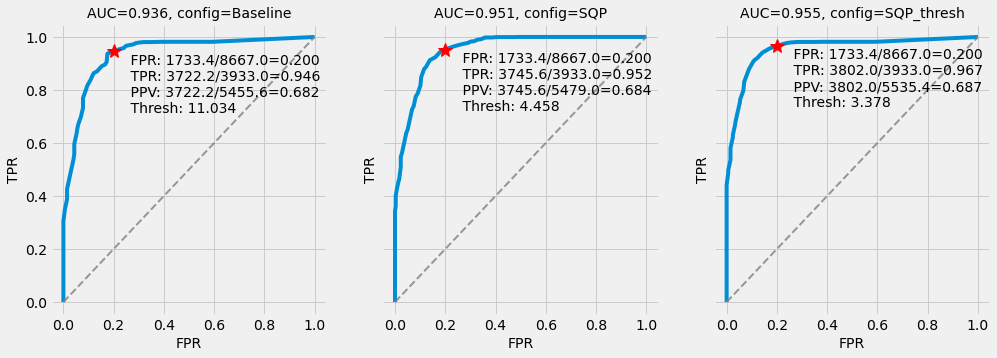

In [ ]:
# Plot ROC
config_list = [config_baseline, config_sqp, config_sqp_thresh]
plot_ROC_curves(data, params, config_list, target_fpr=0.2, plot_truth=False)

Train after initializing using the same initialization as for SGD.

In [ ]:
# Initialize parameters
model_params_sgd = get_init_parameters()
config_random = model_params_to_config_sgd(model_params_sgd)
config_random.name = 'Init'
model_params = config_to_model_params(config_random)
print('Init config:\n\n{}\n'.format(config_random))

#Initial loss
init_loss = compute_loss_from_config(config_random, data, y)
print('Init loss = %.5f\n' % init_loss)

# Optimize with constraints
opt, cache = train_with_optimizer(
  compute_loss_and_grad,
  model_params, 
  args=(config_random.ble_thresholds, data, y), 
  method='SLSQP',
  tol=1e-6
)

# Print optimization output
print('Optimization results:\n\n{}\n'.format(opt))

# Create out config
config_out = RiskConfig()
config_out.ble_thresholds = config_random.ble_thresholds
config_out.name = 'SPQ from SGD init'

# Create learned config
config_sqp_thresh_sgd_init = model_params_to_config(opt.x, config_out)
print('Learned config:\n\n{}\n'.format(config_sqp_thresh_sgd_init))

# Compare losses
y_hat = prob_risk_score_grid(data, config_sqp_thresh_sgd_init)
learned_loss = ce_loss(y, y_hat)
learned_loss_true = ce_loss(y_labels, y_hat)
losses = (learned_loss, learned_loss_true)
print('\nLearned loss = %.5f\nLearned loss (true) = %.5f\n' % losses)

Init config:

RiskConfig(ble_thresholds=array([44.602, 55.602, 81.602], dtype=float32), ble_weights=array([0.02364968, 0.02274239, 0.01475019, 0.00958811], dtype=float32), inf_levels=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0]), inf_weights=array([0.00694876, 0.01451497, 0.02241149], dtype=float32), name='Init', beta=DeviceArray(0.1, dtype=float32))

Init loss = 0.02458

Optimization results:

     fun: 0.020549824461340904
     jac: array([ 2.67660198e-05, -3.15441430e-05,  2.20944406e-04,  0.00000000e+00,
       -1.04468054e-05, -5.58117426e-06,  2.12860905e-05])
 message: 'Optimization terminated successfully.'
    nfev: 37
     nit: 32
    njev: 32
  status: 0
 success: True
       x: array([1.2464206 , 0.77404889, 0.08200043, 0.00958811, 0.03778258,
       0.27569635, 1.41641395])

Learned config:

RiskConfig(ble_thresholds=array([44.602, 55.602, 81.602], dtype=float32), ble_weights=array([1.2464206 , 0.77404889, 0.08200043,

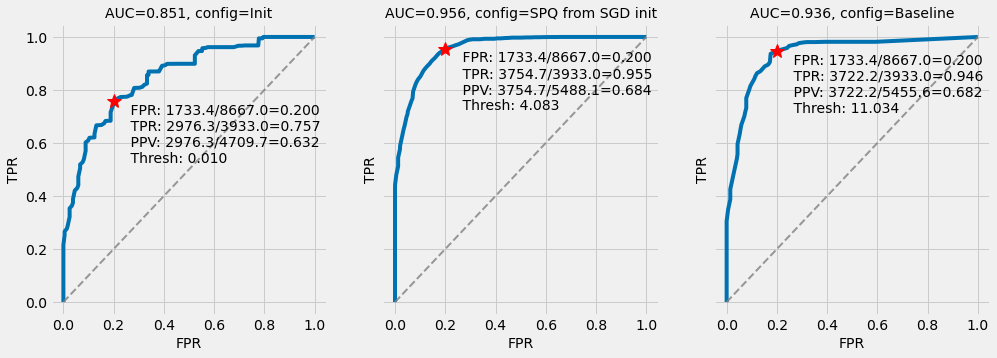

In [ ]:
# ROC curves
config_list = [config_random, config_sqp_from_sgd_init, config_baseline]
plot_ROC_curves(data, params, config_list, target_fpr=0.2, plot_truth=False)

### SQP (AUC)

In [ ]:
# Define output config (empty parameters are to be learned)
out_config = RiskConfig(
    ble_thresholds = jnp.array([50., 70., 80.]),
    inf_levels = make_infectiousness_params_v2()[0],
    beta = 3.1 * 1e-4,  # Wilson table 1 (divide by 100)
    name = 'SQP_auc'
)

# Initialize parameters
model_params = config_to_model_params(config_baseline)
model_params = np.clip(model_params, 0.01, 100)  # 0.01 is the min on ENS
config_random = model_params_to_config(model_params, out_config)

# Optimize with constraints
opt, cache = train_with_optimizer(
  compute_wmw_loss_and_grad,
  model_params, 
  args=(config_random.ble_thresholds, data, y), 
  method='SLSQP',
  tol=1e-8
)

# Print optimization output
print(opt)

# Print learned configuration
config_wmw = model_params_to_config(opt.x, out_config)
print(config_wmw)

     fun: 1.9473098291200586e-05
     jac: array([ 2.13102285e-05, -5.29818244e-05,  2.17125080e-06,  2.71406378e-07,
        2.96290218e-05,  3.69962800e-05,  5.94888334e-05])
 message: 'Optimization terminated successfully.'
    nfev: 35
     nit: 23
    njev: 23
  status: 0
 success: True
       x: array([1.92941348, 0.01707525, 0.00995113, 0.00995113, 0.00441646,
       0.00885142, 0.66865586])
RiskConfig(ble_thresholds=DeviceArray([50., 70., 80.], dtype=float32), ble_weights=array([1.92941348, 0.01707525, 0.00995113, 0.00995113]), inf_levels=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0]), inf_weights=array([0.00441646, 0.00885142, 0.66865586]), name='SQP_auc', beta=0.00031)


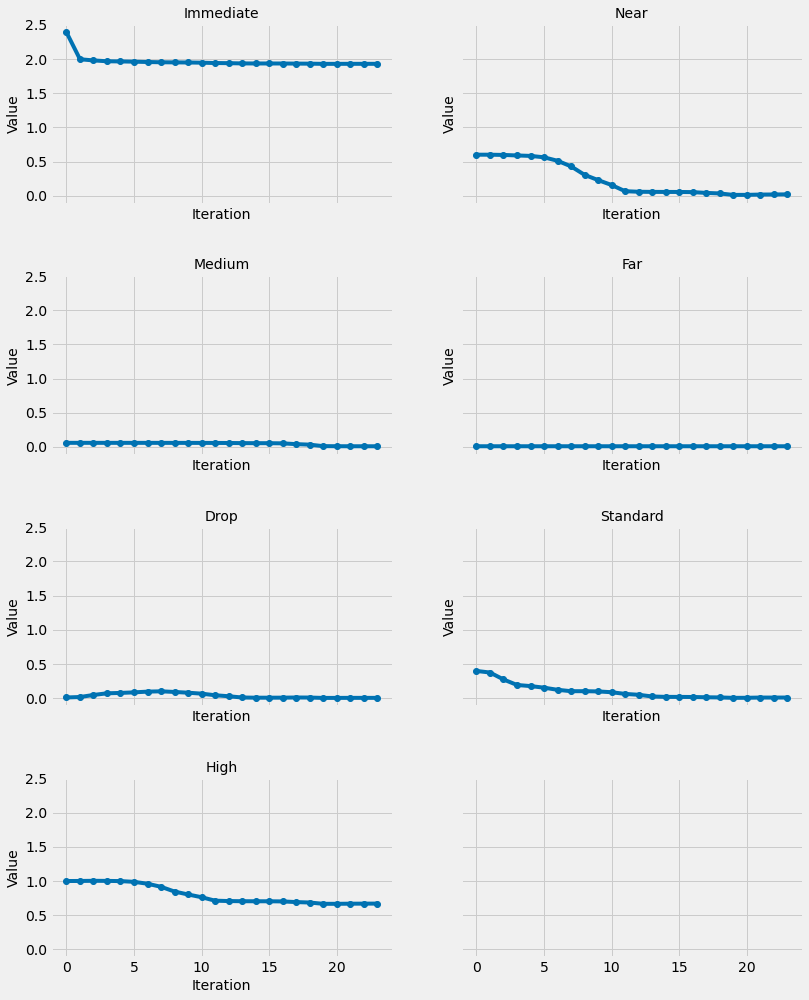

In [ ]:
# Coefficient trajectory
param_names = ['Immediate', 'Near', 'Medium', 'Far', 'Drop', 'Standard', 'High']
trajectories = np.array(cache).T
n = trajectories.shape[1]
x = np.arange(0, n, 1)
fig, axs = plt.subplots(4,2, figsize=(12,16), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.4)
axs = np.reshape(axs, (8,))
for i, trajectory in enumerate(trajectories):
  ax = axs[i]
  ax.plot(x, trajectory, 'o-')
  ax.set_title('{}'.format(param_names[i]))
  ax.set_xlabel('Iteration')
  ax.set_ylabel('Value')

In [ ]:
# ROC curves
config_list = [config_baseline, config_wmw]
plot_ROC_curves(data, params, config_list, target_fpr=0.2)

## Experiments

### SGD vs. SQP

In [ ]:
n_trials = 50
init_params = []
np.random.seed(191707)
for i in range(n_trials):
  init_param = get_init_parameters()
  init_params.append(init_param)

It takes about 15s/trial for SGD with soft thresholds, 40s/trial for SGD with hard thresholds and 25s/trial for SQP. The whole cell runs within ~ 44 minutes for 50 trials - this may be substantially sped up using [Pyflock](https://github.com/Captalys/Flock).

In [ ]:
sqp_configs = []
sgd_step_configs = []
sgd_temp_configs = []

sqp_aucs_train = []
sgd_step_aucs_train = []
sgd_temp_aucs_train = []

sqp_aucs_test = []
sgd_step_aucs_test = []
sgd_temp_aucs_test = []

N = len(init_params)

for n, init_param in enumerate(init_params, 1):
  print('------------------- Trial {}/{} -------------------\n'.format(n, N))
  # Train
  _, sqp_config, _ = train('SQP', init_param, train_config_sqp, data, y)
  _, sgd_step_config, _ = train('SGD', init_param, train_config_step, data, y)
  _, sgd_temp_config, _ = train('SGD', init_param, train_config_temp, data, y, learn_thresholds=True)
  
  # Store
  sqp_configs.append(sqp_config)
  sgd_step_configs.append(sgd_step_config)
  sgd_temp_configs.append(sgd_temp_config)

  # Evaluate in train
  sqp_metrics = compute_ROC_curve(data, sqp_config)
  sgd_step_metrics = compute_ROC_curve(data, sgd_step_config)
  sgd_temp_metrics = compute_ROC_curve(data, sgd_temp_config)

  # Store
  sqp_aucs_train.append(sqp_metrics['auc'])
  sgd_step_aucs_train.append(sgd_step_metrics['auc'])
  sgd_temp_aucs_train.append(sgd_temp_metrics['auc'])

  # Evaluate in test
  sqp_metrics = compute_ROC_curve(data_test, sqp_config)
  sgd_step_metrics = compute_ROC_curve(data_test, sgd_step_config)
  sgd_temp_metrics = compute_ROC_curve(data_test, sgd_temp_config)

  # Store
  sqp_aucs_test.append(sqp_metrics['auc'])
  sgd_step_aucs_test.append(sgd_step_metrics['auc'])
  sgd_temp_aucs_test.append(sgd_temp_metrics['auc'])

------------------- Trial 1/50 -------------------

True loss = 0.01795

Init config:

RiskConfig(ble_thresholds=array([33.602, 62.602, 84.602], dtype=float32), ble_weights=array([0.02210963, 0.0210698 , 0.01235413, 0.00311598], dtype=float32), inf_levels=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0]), inf_weights=array([0.00154511, 0.00344585, 0.01110306], dtype=float32), name='Init', beta=DeviceArray(0.1, dtype=float32))

Init loss (probs) = 0.02750
Init loss (labs) = 0.02306

Learned config (SQP):

RiskConfig(ble_thresholds=array([33.602, 62.602, 84.602], dtype=float32), ble_weights=array([1.1348349 , 0.87690542, 0.04163297, 0.00217212]), inf_levels=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0]), inf_weights=array([0.03342926, 0.30146364, 1.40459826]), name='SQP', beta=0.00031)


Learned loss (probs) = 0.02079
Learned loss (labs) = 0.01829

True loss = 0.01795

Init config:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[array(seq)]` instead of `arr[seq]`. In the future this will result in a TypeError. See https://github.com/google/jax/issues/4564 for discussion of why this type of indexing is being deprecated.


Streaming output truncated to the last 5000 lines.
Init loss (probs) = 0.02869
Init loss (labs) = 0.02412

Learned config (SQP):

RiskConfig(ble_thresholds=array([47.602, 69.602, 82.602], dtype=float32), ble_weights=array([1.38015274e+00, 5.60309924e-01, 5.91022241e-04, 1.21672174e-04]), inf_levels=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0]), inf_weights=array([0.02292569, 0.25394426, 1.22145913]), name='SQP', beta=0.00031)


Learned loss (probs) = 0.02080
Learned loss (labs) = 0.01833

True loss = 0.01795

Init config:

RiskConfig(ble_thresholds=array([47.602, 69.602, 82.602], dtype=float32), ble_weights=array([0.01895897, 0.01842318, 0.01506948, 0.00757523], dtype=float32), inf_levels=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0]), inf_weights=array([0.00282014, 0.00577433, 0.00726583], dtype=float32), name='Init', beta=DeviceArray(0.1, dtype=float32))

Init loss (probs) =

Dump to Google Drive.

In [ ]:
# Save
sqp_file = '/content/drive/My Drive/Research/Kevin Murphy/mini-project/output/sqp_fle.pickle'
sgd_step_file = '/content/drive/My Drive/Research/Kevin Murphy/mini-project/output/sgd_step_fle.pickle'
sgd_temp_file = '/content/drive/My Drive/Research/Kevin Murphy/mini-project/output/sgd_temp_fle.pickle'

with open(sqp_file, 'wb') as file:
  pickle.dump(sqp_configs, file)
with open(sgd_step_file, 'wb') as file:
  pickle.dump(sgd_step_configs, file)
with open(sgd_temp_file, 'wb') as file:
  pickle.dump(sgd_temp_configs, file)

Load from Google Drive.

In [ ]:
# Define filepaths
sqp_file = '/content/drive/My Drive/Research/Kevin Murphy/mini-project/output/sqp_fle.pickle'
sgd_step_file = '/content/drive/My Drive/Research/Kevin Murphy/mini-project/output/sgd_step_fle.pickle'
sgd_temp_file = '/content/drive/My Drive/Research/Kevin Murphy/mini-project/output/sgd_temp_fle.pickle'

# Read files
with (open(sqp_file, "rb")) as file:
  sqp_configs = pickle.load(file)
with (open(sgd_step_file, "rb")) as file:
  sgd_step_configs = pickle.load(file)
with (open(sgd_temp_file, "rb")) as file:
  sgd_temp_configs = pickle.load(file)

# Initialize lists
sqp_aucs_train = []
sgd_step_aucs_train = []
sgd_temp_aucs_train = []

sqp_aucs_test = []
sgd_step_aucs_test = []
sgd_temp_aucs_test = []

# Compute AUCs
configs = list(zip(sqp_configs, sgd_step_configs, sgd_temp_configs))
for sqp_config, sgd_step_config, sgd_temp_config in configs:
# Evaluate in train
  sqp_metrics = compute_ROC_curve(data, sqp_config)
  sgd_step_metrics = compute_ROC_curve(data, sgd_step_config)
  sgd_temp_metrics = compute_ROC_curve(data, sgd_temp_config)

  # Store
  sqp_aucs_train.append(sqp_metrics['auc'])
  sgd_step_aucs_train.append(sgd_step_metrics['auc'])
  sgd_temp_aucs_train.append(sgd_temp_metrics['auc'])

  # Evaluate in test
  sqp_metrics = compute_ROC_curve(data_test, sqp_config)
  sgd_step_metrics = compute_ROC_curve(data_test, sgd_step_config)
  sgd_temp_metrics = compute_ROC_curve(data_test, sgd_temp_config)

  # Store
  sqp_aucs_test.append(sqp_metrics['auc'])
  sgd_step_aucs_test.append(sgd_step_metrics['auc'])
  sgd_temp_aucs_test.append(sgd_temp_metrics['auc'])

In [ ]:
# Summary statistics
print(np.quantile(sgd_temp_aucs_train, [0.25, 0.5, 0.75]))
print(np.quantile(sgd_step_aucs_train, [0.25, 0.5, 0.75]))
print(np.quantile(sqp_aucs_train, [0.25, 0.5, 0.75]))

print(np.quantile(sgd_temp_aucs_test, [0.25, 0.5, 0.75]))
print(np.quantile(sgd_step_aucs_test, [0.25, 0.5, 0.75]))
print(np.quantile(sqp_aucs_test, [0.25, 0.5, 0.75]))

[0.93693063 0.94738479 0.95199522]
[0.93156241 0.94258338 0.9480895 ]
[0.94095252 0.95096734 0.9564754 ]
[0.92722336 0.94337429 0.951063  ]
[0.92133913 0.93679455 0.94424843]
[0.93102933 0.94712487 0.95519905]


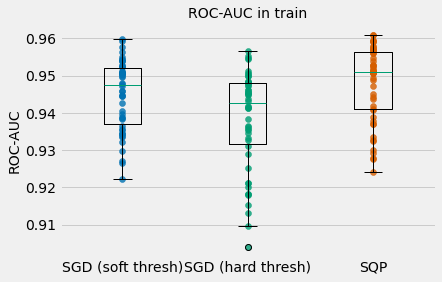

In [ ]:
aucs = [sgd_temp_aucs_train, sgd_step_aucs_train, sqp_aucs_train]
plt.boxplot(aucs, labels=['SGD (soft thresh)', 'SGD (hard thresh)', 'SQP'])
plt.scatter(np.full(N, 1), sgd_temp_aucs_train, alpha=0.8)
plt.scatter(np.full(N, 2), sgd_step_aucs_train, alpha=0.8)
plt.scatter(np.full(N, 3), sqp_aucs_train, alpha=0.8)
plt.title('ROC-AUC in train')
plt.ylabel('ROC-AUC')
ax = plt.gca()
ax.xaxis.grid(False)

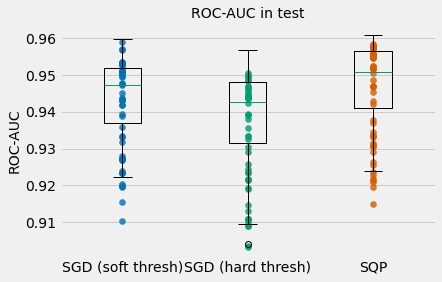

In [ ]:
aucs = [sgd_temp_aucs_train, sgd_step_aucs_train, sqp_aucs_train]
plt.boxplot(aucs, labels=['SGD (soft thresh)', 'SGD (hard thresh)', 'SQP'])
plt.scatter(np.full(N, 1), sgd_temp_aucs_test, alpha=0.8)
plt.scatter(np.full(N, 2), sgd_step_aucs_test, alpha=0.8)
plt.scatter(np.full(N, 3), sqp_aucs_test, alpha=0.8)
plt.title('ROC-AUC in test')
plt.ylabel('ROC-AUC')
ax = plt.gca()
ax.xaxis.grid(False)

Percent AUCs greater for SQP than SGD (hard) = 0.96
Percent AUCs greater for SQP than SGD (soft) = 0.82



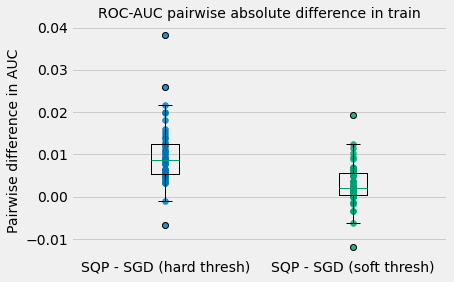

In [ ]:
a = np.array(sqp_aucs_train) - np.array(sgd_step_aucs_train)
prob = np.mean(np.array(sqp_aucs_train) > np.array(sgd_step_aucs_train))
print('Percent AUCs greater for SQP than SGD (hard) = %.2f' % prob)
b = np.array(sqp_aucs_train) - np.array(sgd_temp_aucs_train)
prob = np.mean(np.array(sqp_aucs_train) > np.array(sgd_temp_aucs_train))
print('Percent AUCs greater for SQP than SGD (soft) = %.2f\n' % prob)
aucs = [a, b]

plt.boxplot(aucs, labels=['SQP - SGD (hard thresh)', 'SQP - SGD (soft thresh)'])
plt.scatter(np.full(N, 1), a, alpha=0.8)
plt.scatter(np.full(N, 2), b, alpha=0.8)
plt.title('ROC-AUC pairwise absolute difference in train')
plt.ylabel('Pairwise difference in AUC')
ax = plt.gca()
ax.xaxis.grid(False)

In [ ]:
print(scipy.stats.wilcoxon(sqp_aucs_train, sgd_step_aucs_train))
print(scipy.stats.wilcoxon(sqp_aucs_train, sgd_temp_aucs_train))

WilcoxonResult(statistic=22.0, pvalue=2.8226548342339874e-09)
WilcoxonResult(statistic=193.0, pvalue=1.7796456927994258e-05)


Percent AUCs greater for SQP than SGD (hard) = 0.98
Percent AUCs greater for SQP than SGD (soft) = 0.82



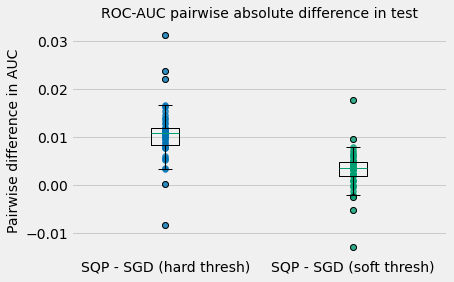

In [ ]:
a = np.array(sqp_aucs_test) - np.array(sgd_step_aucs_test)
prob = np.mean(np.array(sqp_aucs_test) > np.array(sgd_step_aucs_test))
print('Percent AUCs greater for SQP than SGD (hard) = %.2f' % prob)
b = np.array(sqp_aucs_test) - np.array(sgd_temp_aucs_test)
prob = np.mean(np.array(sqp_aucs_test) > np.array(sgd_temp_aucs_test))
print('Percent AUCs greater for SQP than SGD (soft) = %.2f\n' % prob)
aucs = [a, b]

plt.boxplot(aucs, labels=['SQP - SGD (hard thresh)', 'SQP - SGD (soft thresh)'])
plt.scatter(np.full(N, 1), a, alpha=0.8)
plt.scatter(np.full(N, 2), b, alpha=0.8)
plt.title('ROC-AUC pairwise absolute difference in test')
plt.ylabel('Pairwise difference in AUC')
ax = plt.gca()
ax.xaxis.grid(False)

In [ ]:
print(scipy.stats.wilcoxon(sqp_aucs_test, sgd_step_aucs_test))
print(scipy.stats.wilcoxon(sqp_aucs_test, sgd_temp_aucs_test))

WilcoxonResult(statistic=13.0, pvalue=1.6551652076305667e-09)
WilcoxonResult(statistic=145.0, pvalue=1.9919455004886565e-06)


Using the paired nature of the experiment, the following boxplot clearly shows that in this setting SQP is more likely to yield a higher ROC-AUC, than either SQP with hard (Wilcoxon signed rank test p-value, 10^-9) or soft (Wilcoxon signed-rank test p-value, 10^-6) thresholds. Specifically, out of 50 trials, SQP gave a better minimum 48/50 times from SGD with hard thresholds and 41/50 times from SGD with soft thresholds. Similarly, the median pairwise absolute difference was smaller for soft than hard thresholds with SGD. It took 44 minutes for this experiment to run.

### Train vs. Test

Percent train AUCs greater than test AUCs for SGD temp = 0.78
Percent train AUCs greater than test AUCs for SGD step = 0.78
Percent train AUCs greater than test AUCs for SQP = 0.80


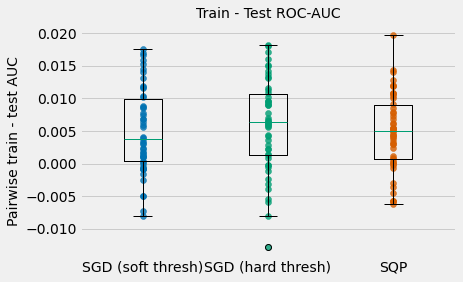

In [ ]:
# Compute differences
sgd_temp_diffs = np.array(sgd_temp_aucs_train) - np.array(sgd_temp_aucs_test)
sgd_step_diffs = np.array(sgd_step_aucs_train) - sgd_step_aucs_test
sqp_diffs = np.array(sqp_aucs_train) - np.array(sqp_aucs_test)

# Summary
prob = np.mean(np.array(sgd_temp_diffs) > 0)
print('Percent train AUCs greater than test AUCs for SGD temp = %.2f' % prob)
prob = np.mean(np.array(sgd_step_diffs) > 0)
print('Percent train AUCs greater than test AUCs for SGD step = %.2f' % prob)
prob = np.mean(np.array(sqp_diffs) > 0)
print('Percent train AUCs greater than test AUCs for SQP = %.2f' % prob)

# Plot
N = len(sgd_temp_diffs)
diffs = [sgd_temp_diffs, sgd_step_diffs, sqp_diffs]
plt.boxplot(diffs, labels=['SGD (soft thresh)', 'SGD (hard thresh)', 'SQP'])
plt.scatter(np.full(N, 1), sgd_temp_diffs, alpha=0.8)
plt.scatter(np.full(N, 2), sgd_step_diffs, alpha=0.8)
plt.scatter(np.full(N, 3), sqp_diffs, alpha=0.8)
plt.ylabel('Pairwise train - test AUC')
plt.title('Train - Test ROC-AUC')
ax = plt.gca()
ax.xaxis.grid(False)

### Init vs. Final loss

Initial vs. final loss for SQP.

Text(0, 0.5, 'Loss after optimization')

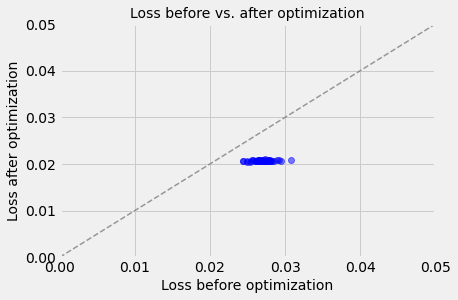

In [ ]:
init_losses = []
for init_param in init_params:
  config_random = model_params_to_config_sgd(init_param)
  init_loss = compute_loss_from_config(config_random, data, y)
  init_losses.append(init_loss)

final_losses = []
for sqp_config in sqp_configs:
  final_loss = compute_loss_from_config(sqp_config, data, y)
  final_losses.append(final_loss)

plt.plot(init_losses, final_losses, 'o', color='blue', alpha=0.5)
plt.plot([0, 1], [0, 1], linestyle='--', lw=1.5, color='gray', alpha=0.8)
plt.xlim(0, 0.05)
plt.ylim(0, 0.05)
plt.title('Loss before vs. after optimization')
plt.xlabel('Loss before optimization')
plt.ylabel("Loss after optimization")

### Hard vs. soft labels

In train.

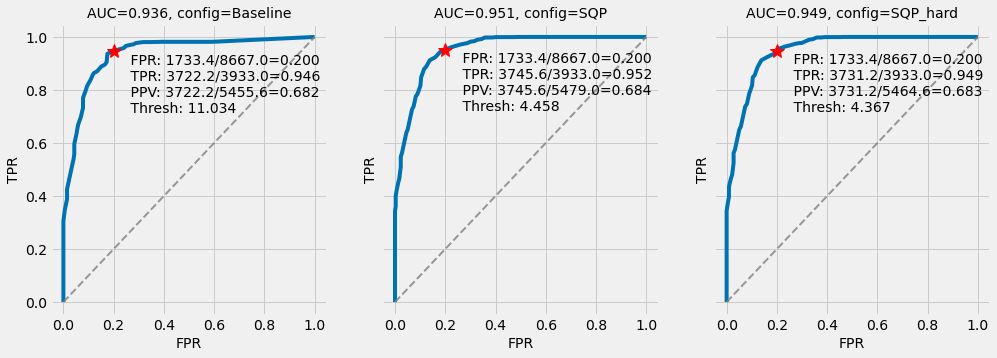

In [ ]:
config_list = [config_baseline, config_sqp, config_sqp_hard]
plot_ROC_curves(data, params, config_list, target_fpr=0.2)

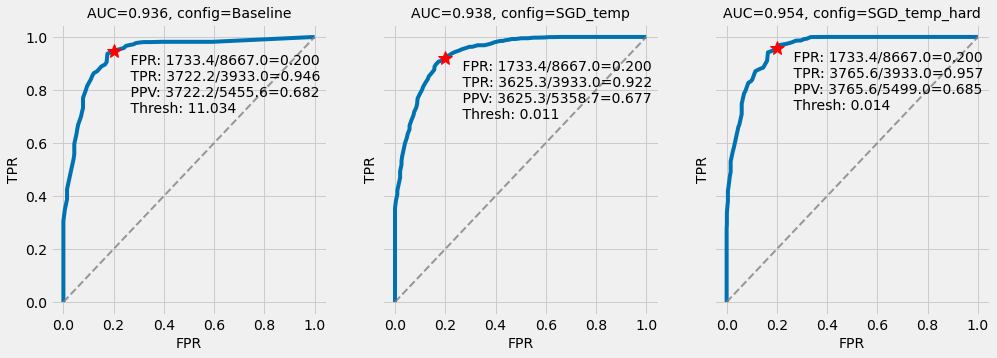

In [ ]:
config_list = [config_baseline, config_sgd_temp, config_sgd_temp_hard]
plot_ROC_curves(data, params, config_list, target_fpr=0.2)

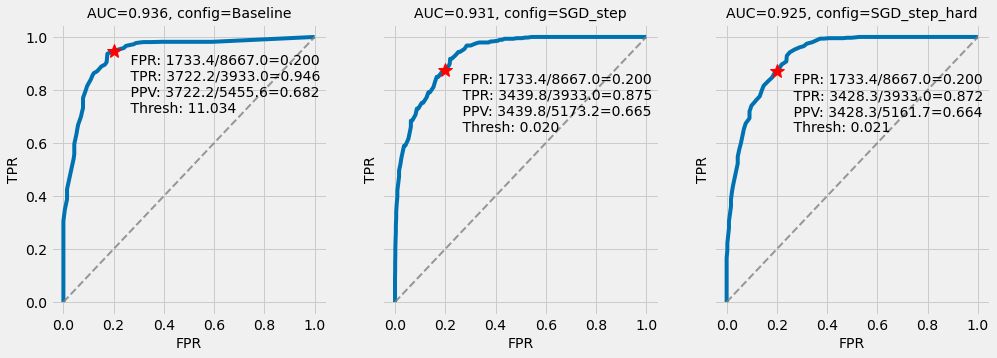

In [ ]:
config_list = [config_baseline, config_sgd_step, config_sgd_step_hard]
plot_ROC_curves(data, params, config_list, target_fpr=0.2)

In test.

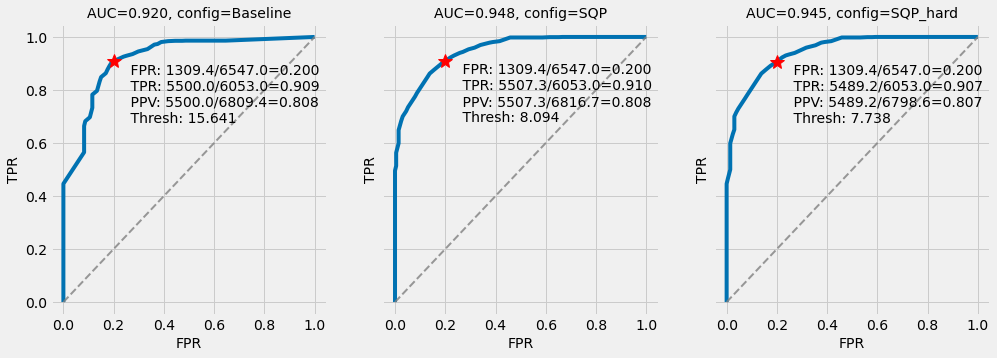

In [ ]:
config_list = [config_baseline, config_sqp, config_sqp_hard]
plot_ROC_curves(data_test, params, config_list, target_fpr=0.2)

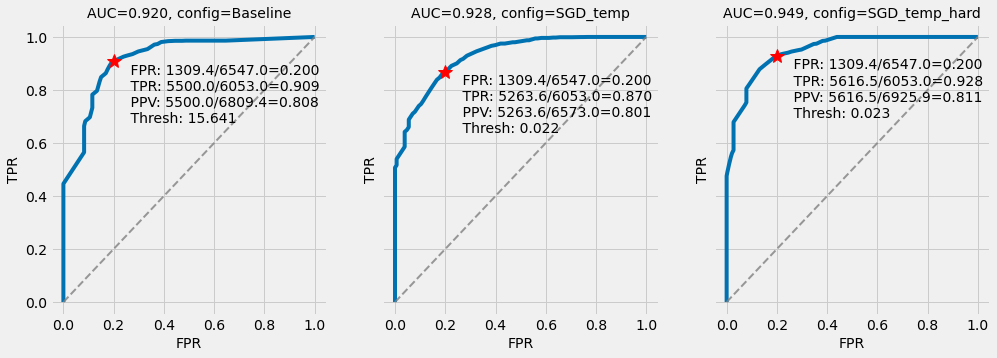

In [ ]:
config_list = [config_baseline, config_sgd_temp, config_sgd_temp_hard]
plot_ROC_curves(data_test, params, config_list, target_fpr=0.2)

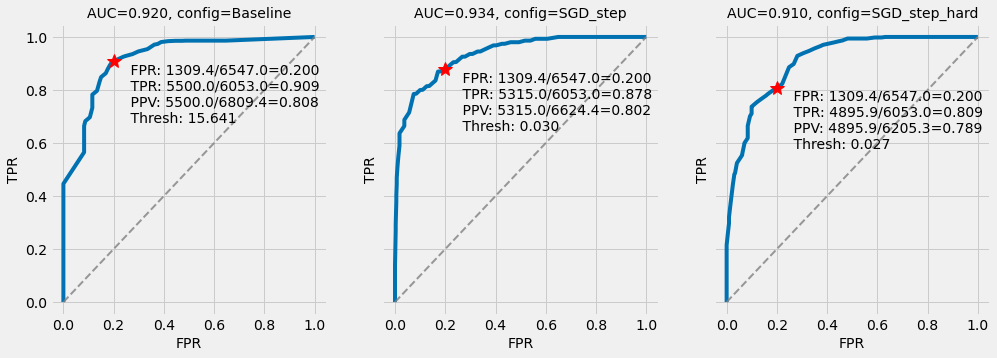

In [ ]:
config_list = [config_baseline, config_sgd_step, config_sgd_step_hard]
plot_ROC_curves(data_test, params, config_list, target_fpr=0.2)

### Varying grid size

In [ ]:
# Create sparse data
densities = [2, 4, 6, 8]
sparse_grids = []
sparse_ys = []
params = ModelParams()
for density in densities:
  data_sparse = make_input_data_train(density=density)
  y_sparse = prob_infection_grid(data_sparse, params)
  sparse_grids.append(data_sparse)
  sparse_ys.append(y_sparse)

# Prepare values
N = len(init_params)
n_inits = 10
sparse_train = zip(sparse_grids, sparse_ys)

# Initialize objects
sqp_configs_sparse = []
sqp_metrics_sparse = []
sqp_aucs_train_sparse = []
sqp_metrics_sparse = []
sqp_aucs_test_sparse = []

# Train
for data_sparse, y_sparse in sparse_train:
  for n, init_param in enumerate(init_params[:n_inits], 1):
    print('------------------- Trial {}/{} -------------------\n'.format(n, N))
    # Train
    _, sqp_config_sparse, _ = train('SQP', init_param, train_config_sqp, data, y)
    sqp_configs_sparse.append(sqp_config_sparse)

    # Evaluate in train
    params = ModelParams()
    sqp_metrics_sparse = compute_ROC_curve(data, sqp_config_sparse)
    sqp_aucs_train_sparse.append(sqp_metrics_sparse['auc'])

    # Evaluate in test
    sqp_metrics_sparse = compute_ROC_curve(data_test, sqp_config_sparse)
    sqp_aucs_test_sparse.append(sqp_metrics_sparse['auc'])

------------------- Trial 1/50 -------------------

True loss = 0.01795

Init config:

RiskConfig(ble_thresholds=array([33.602, 62.602, 84.602], dtype=float32), ble_weights=array([0.02267105, 0.02148898, 0.01263107, 0.00325445], dtype=float32), inf_levels=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0]), inf_weights=array([0.00197968, 0.0042879 , 0.01216089], dtype=float32), name='Init', beta=DeviceArray(0.10003098, dtype=float32))

Init loss (probs) = 0.02701
Init loss (labs) = 0.02268

Learned config (SQP):

RiskConfig(ble_thresholds=array([33.602, 62.602, 84.602], dtype=float32), ble_weights=array([1.16109072, 0.88612308, 0.0700372 , 0.00787185]), inf_levels=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0]), inf_weights=array([0.04253696, 0.2402305 , 1.4322202 ]), name='SQP', beta=0.00031)


Learned loss (probs) = 0.02080
Learned loss (labs) = 0.01822

------------------- Trial 2

Dump on Google Drive.

In [ ]:
# Save
sqp_file = '/content/drive/My Drive/Research/Kevin Murphy/mini-project/output/sqp_configs_sparse.pickle'

with open(sqp_file, 'wb') as file:
  pickle.dump(sqp_configs_sparse, file)

Load from Google Drive.

In [ ]:
# Define filepaths
sqp_file = '/content/drive/My Drive/Research/Kevin Murphy/mini-project/output/sqp_configs_sparse.pickle'

# Read files
with (open(sqp_file, "rb")) as file:
  sqp_configs_sparse = pickle.load(file)

# Initialize lists
sqp_aucs_train_sparse = []
sqp_aucs_test_sparse = []

# Compute AUCs
for sqp_config in sqp_configs_sparse:
# Evaluate in train
  params = ModelParams()
  sqp_metrics = compute_ROC_curve(data, sqp_config)
  sqp_aucs_train_sparse.append(sqp_metrics['auc'])

  # Evaluate in test
  sqp_metrics = compute_ROC_curve(data_test, sqp_config)
  sqp_aucs_test_sparse.append(sqp_metrics['auc'])

Plot in train.

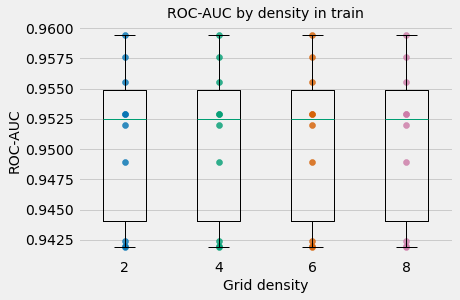

In [ ]:
# Split AUCs
n = len(sqp_aucs_train_sparse)
aucs = [sqp_aucs_train_sparse[i:i+n_inits] for i in range(0, n, n_inits)]

# Plot
plt.boxplot(aucs, labels=['2', '4', '6', '8'])
plt.scatter(np.full(n_inits, 1), aucs[0], alpha=0.8)
plt.scatter(np.full(n_inits, 2), aucs[1], alpha=0.8)
plt.scatter(np.full(n_inits, 3), aucs[2], alpha=0.8)
plt.scatter(np.full(n_inits, 4), aucs[3], alpha=0.8)
plt.title('ROC-AUC by density in train')
plt.xlabel('Grid density')
plt.ylabel('ROC-AUC')
ax = plt.gca()
ax.xaxis.grid(False)

Plot in test.

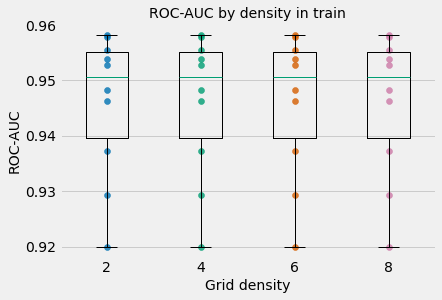

In [ ]:
# Split AUCs
n = len(sqp_aucs_test_sparse)
aucs = [sqp_aucs_test_sparse[i:i+n_inits] for i in range(0, n, n_inits)]

# Plot
plt.boxplot(aucs, labels=['2', '4', '6', '8'])
plt.scatter(np.full(n_inits, 1), aucs[0], alpha=0.8)
plt.scatter(np.full(n_inits, 2), aucs[1], alpha=0.8)
plt.scatter(np.full(n_inits, 3), aucs[2], alpha=0.8)
plt.scatter(np.full(n_inits, 4), aucs[3], alpha=0.8)
plt.title('ROC-AUC by density in test')
plt.xlabel('Grid density')
plt.ylabel('ROC-AUC')
ax = plt.gca()
ax.xaxis.grid(False)

## Evaluate configurations

### Best config

In [ ]:
# Configs and performance
all_configs = sgd_temp_configs + sgd_step_configs + sqp_configs
all_aucs = sgd_temp_aucs_test + sgd_step_aucs_test + sqp_aucs_test

# Best AUC
idx_max = np.argmax(all_aucs)
config_best = all_configs[idx_max]
config_best.name = 'best_config'

# Print best config
print('Best config:\n\n{}'.format(config_best))

Best config:

RiskConfig(ble_thresholds=array([47.602, 60.602, 84.602], dtype=float32), ble_weights=array([0.07311635, 0.03476435, 0.00199031, 0.00101538], dtype=float32), inf_levels=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0]), inf_weights=array([0.00158742, 0.01402746, 0.06189849], dtype=float32), name='best_config', beta=array(0.11120934, dtype=float32))


### Discrimination

ROC in train.

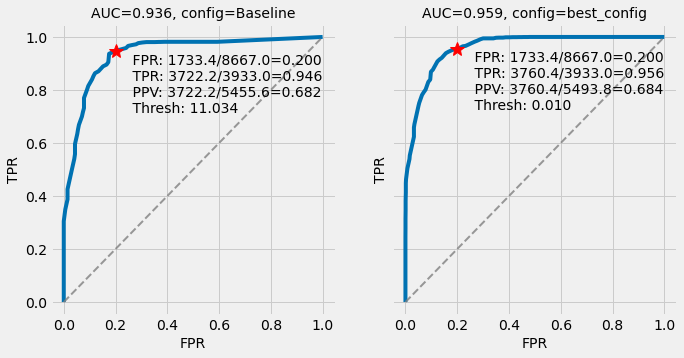

In [ ]:
np.random.seed(42150)
config_list = [config_baseline, config_best]
plot_ROC_curves(data, params, config_list, target_fpr=0.2)

ROC in test.

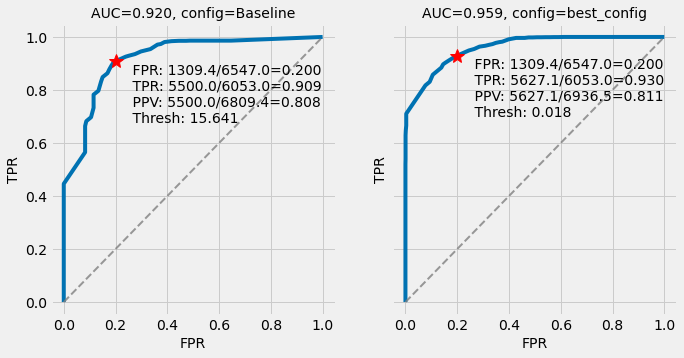

In [ ]:
np.random.seed(42150)
config_list = [config_baseline, config_best]
plot_ROC_curves(data_test, params, config_list, target_fpr=0.2)

### Calibration

Calibration in train.

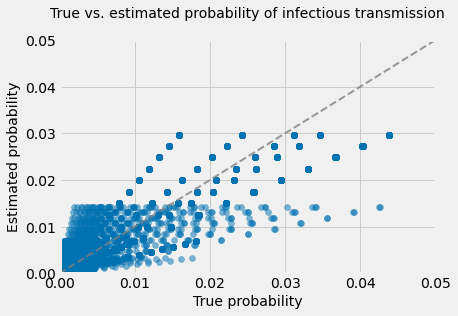

In [ ]:
y_hat = prob_risk_score_grid(data, config_best)
plt.scatter(y, y_hat, alpha = 0.5)
plt.xlabel('True probability')
plt.ylabel('Estimated probability')
plt.title('True vs. estimated probability of infectious transmission\n')
plt.xlim(0, 0.05)
plt.ylim(0, 0.05)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray', alpha=0.8)

Calibration in test.

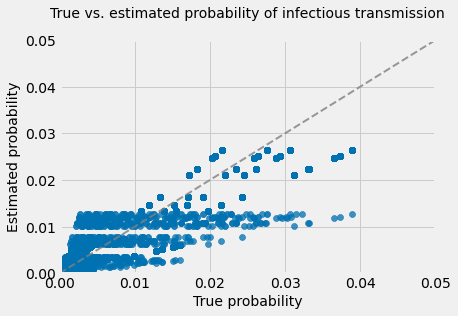

In [ ]:
y_hat = prob_risk_score_grid(data_test, config_best)
plt.scatter(y_test, y_hat, alpha = 0.5)
plt.xlabel('True probability')
plt.ylabel('Estimated probability')
plt.title('True vs. estimated probability of infectious transmission\n')
plt.xlim(0, 0.05)
plt.ylim(0, 0.05)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray', alpha=0.8)